# APN Utilization

In [ ]:
!pip install nbeats_keras

In [ ]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np

from matplotlib import pyplot
import seaborn as sns
sns.set()

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout

from math import sqrt
from matplotlib import pyplot
import matplotlib.pyplot as plt

from datetime import datetime

In [ ]:
from google.colab import files
!ls

sample_data


In [ ]:
from google.colab import files
!rm 'apn_utilization_hourly_3months_50nodes.csv'

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving apn_utilization_hourly_3months_50nodes.csv to apn_utilization_hourly_3months_50nodes.csv


In [ ]:
# LOAD DATASET
apn = pd.read_csv('apn_utilization_hourly_3months_50nodes.csv', index_col=0, parse_dates=True)

In [ ]:
# DISPLAY FIRST FIVE ROWS
apn.head()

,Unnamed: 1,"1/01/21, 00:00","1/01/21, 01:00","1/01/21, 02:00","1/01/21, 03:00","1/01/21, 04:00","1/01/21, 05:00","1/01/21, 06:00","1/01/21, 07:00","1/01/21, 08:00","1/01/21, 09:00","1/01/21, 10:00","1/01/21, 11:00","1/01/21, 12:00","1/01/21, 13:00","1/01/21, 14:00","1/01/21, 15:00","1/01/21, 16:00","1/01/21, 17:00","1/01/21, 18:00","1/01/21, 19:00","1/01/21, 20:00","1/01/21, 21:00","1/01/21, 22:00","1/01/21, 23:00","2/01/21, 00:00","2/01/21, 01:00","2/01/21, 02:00","2/01/21, 03:00","2/01/21, 04:00","2/01/21, 05:00","2/01/21, 06:00","2/01/21, 07:00","2/01/21, 08:00","2/01/21, 09:00","2/01/21, 10:00","2/01/21, 11:00","2/01/21, 12:00","2/01/21, 13:00","2/01/21, 14:00",...,"30/03/21, 08:00","30/03/21, 09:00","30/03/21, 10:00","30/03/21, 11:00","30/03/21, 12:00","30/03/21, 13:00","30/03/21, 14:00","30/03/21, 15:00","30/03/21, 16:00","30/03/21, 17:00","30/03/21, 18:00","30/03/21, 19:00","30/03/21, 20:00","30/03/21, 21:00","30/03/21, 22:00","30/03/21, 23:00","31/03/21, 00:00","31/03/21, 01:00","31/03/21, 02:00","31/03/21, 03:00","31/03/21, 04:00","31/03/21, 05:00","31/03/21, 06:00","31/03/21, 07:00","31/03/21, 08:00","31/03/21, 09:00","31/03/21, 10:00","31/03/21, 11:00","31/03/21, 12:00","31/03/21, 13:00","31/03/21, 14:00","31/03/21, 15:00","31/03/21, 16:00","31/03/21, 17:00","31/03/21, 18:00","31/03/21, 19:00","31/03/21, 20:00","31/03/21, 21:00","31/03/21, 22:00","31/03/21, 23:00"
APN_1,Total PS Throughput Gb/s,12.03,10.37,8.36,9.72,8.45,8.17,9.87,10.05,10.43,11.36,13.09,12.30,11.83,15.74,14.69,12.55,12.15,11.92,13.21,13.29,13.88,13.93,13.16,11.87,10.47,8.87,7.05,8.61,7.72,7.95,8.72,7.64,7.36,7.57,8.26,9.44,11.55,12.92,12.28,...,8.49,10.15,10.78,11.74,13.82,14.35,13.54,13.31,13.20,13.45,13.57,14.57,14.56,14.78,13.73,12.05,10.30,8.61,6.84,9.03,8.11,9.61,9.35,8.26,8.72,10.16,10.69,11.69,13.25,13.70,12.97,12.78,12.68,13.08,13.14,14.16,14.25,14.61,13.48,11.91
APN_2,Total PS Throughput Gb/s,5.70,4.92,3.93,4.68,3.98,3.86,4.59,4.65,4.92,5.36,6.11,5.72,5.61,7.42,6.84,5.85,5.72,5.59,6.09,6.18,6.46,6.42,6.01,5.37,4.82,4.05,3.34,3.98,3.55,3.70,4.08,3.61,3.46,3.55,3.95,4.53,5.47,6.12,5.89,...,3.48,4.11,4.47,4.79,5.56,5.78,5.52,5.53,5.51,5.78,5.81,6.20,6.27,6.38,5.83,5.02,4.34,3.62,2.84,3.81,3.51,4.11,3.89,3.40,3.57,4.28,4.42,4.85,5.47,5.67,5.41,5.38,5.27,5.69,5.62,6.05,6.05,6.15,5.75,4.96
APN_3,Total PS Throughput Gb/s,63.72,58.79,51.90,43.40,35.20,28.99,29.60,27.50,26.84,29.50,34.38,36.64,39.64,51.19,53.05,49.68,50.89,50.25,56.69,57.91,60.82,62.17,62.33,61.95,60.39,56.10,49.54,41.86,35.42,29.47,29.35,26.93,26.66,27.88,31.08,36.75,41.83,47.68,50.66,...,41.49,51.70,56.80,65.05,71.69,77.14,76.76,76.15,75.75,78.46,77.33,82.03,83.67,88.05,87.42,85.19,82.06,74.82,65.03,52.85,43.62,41.66,40.60,39.21,44.32,56.21,62.79,69.69,73.53,79.85,82.20,82.47,81.49,79.82,76.54,81.67,81.60,85.88,84.69,83.78
APN_4,Total PS Throughput Gb/s,93.85,88.00,78.44,66.65,54.43,44.65,43.50,39.66,38.20,40.65,47.11,51.62,57.78,72.98,75.57,71.99,74.10,73.72,81.78,82.32,86.28,88.53,89.69,90.09,90.35,84.62,74.54,62.23,52.08,43.39,42.94,38.83,37.36,31.09,45.42,52.72,60.75,70.65,75.12,...,46.20,57.09,63.02,72.08,78.77,83.69,85.21,83.55,83.52,83.71,82.42,87.54,88.24,90.97,90.54,89.48,87.55,81.17,69.64,45.49,47.84,45.21,42.91,42.57,47.93,61.22,69.02,73.70,77.80,83.10,84.42,86.79,84.40,82.86,79.77,84.31,84.78,87.78,90.99,90.38
APN_5,Total PS Throughput Gb/s,130.08,120.76,106.36,88.60,72.09,60.83,62.63,59.90,60.21,65.15,76.64,78.71,86.67,110.39,113.61,107.53,109.95,109.03,120.55,122.55,128.46,131.54,131.37,127.07,123.77,114.50,99.40,83.06,69.23,59.84,60.53,56.54,56.62,60.08,67.99,78.84,91.89,102.37,107.14,...,88.07,108.40,118.57,132.91,149.72,155.10,155.06,155.04,152.58,156.12,154.04,164.94,168.26,176.96,175.56,165.42,157.20,141.77,120.25,99.64,83.56,83.73,81.40,82.37,93.34,115.70,121.97,141.55,147.60,155.74,160.54,161.32,156.42,158.38,152.39,163.05,165.99,172.31,174.92,169.23


In [ ]:
# EXTRACT COLUMNS
cols = apn.columns[2:]

In [ ]:
# CHECK FOR NULL VALUES
apn.isnull().sum().sum()

563

In [ ]:
# IMPUTATION
#apn.fillna(0, axis=1, inplace=True)
apn = apn.fillna(method='bfill')

In [ ]:
# CONFIRM FOR SUCCESSFUL IMPUTATION
apn.isnull().sum().sum()

0

In [ ]:
# DATASET SHAPE
apn.shape

(50, 2161)

In [ ]:
# DROP UNNECESSARY COLUMN
apn.drop('Unnamed: 1', axis=1, inplace=True)

In [ ]:
apn.head()

,"1/01/21, 00:00","1/01/21, 01:00","1/01/21, 02:00","1/01/21, 03:00","1/01/21, 04:00","1/01/21, 05:00","1/01/21, 06:00","1/01/21, 07:00","1/01/21, 08:00","1/01/21, 09:00","1/01/21, 10:00","1/01/21, 11:00","1/01/21, 12:00","1/01/21, 13:00","1/01/21, 14:00","1/01/21, 15:00","1/01/21, 16:00","1/01/21, 17:00","1/01/21, 18:00","1/01/21, 19:00","1/01/21, 20:00","1/01/21, 21:00","1/01/21, 22:00","1/01/21, 23:00","2/01/21, 00:00","2/01/21, 01:00","2/01/21, 02:00","2/01/21, 03:00","2/01/21, 04:00","2/01/21, 05:00","2/01/21, 06:00","2/01/21, 07:00","2/01/21, 08:00","2/01/21, 09:00","2/01/21, 10:00","2/01/21, 11:00","2/01/21, 12:00","2/01/21, 13:00","2/01/21, 14:00","2/01/21, 15:00",...,"30/03/21, 08:00","30/03/21, 09:00","30/03/21, 10:00","30/03/21, 11:00","30/03/21, 12:00","30/03/21, 13:00","30/03/21, 14:00","30/03/21, 15:00","30/03/21, 16:00","30/03/21, 17:00","30/03/21, 18:00","30/03/21, 19:00","30/03/21, 20:00","30/03/21, 21:00","30/03/21, 22:00","30/03/21, 23:00","31/03/21, 00:00","31/03/21, 01:00","31/03/21, 02:00","31/03/21, 03:00","31/03/21, 04:00","31/03/21, 05:00","31/03/21, 06:00","31/03/21, 07:00","31/03/21, 08:00","31/03/21, 09:00","31/03/21, 10:00","31/03/21, 11:00","31/03/21, 12:00","31/03/21, 13:00","31/03/21, 14:00","31/03/21, 15:00","31/03/21, 16:00","31/03/21, 17:00","31/03/21, 18:00","31/03/21, 19:00","31/03/21, 20:00","31/03/21, 21:00","31/03/21, 22:00","31/03/21, 23:00"
APN_1,12.03,10.37,8.36,9.72,8.45,8.17,9.87,10.05,10.43,11.36,13.09,12.30,11.83,15.74,14.69,12.55,12.15,11.92,13.21,13.29,13.88,13.93,13.16,11.87,10.47,8.87,7.05,8.61,7.72,7.95,8.72,7.64,7.36,7.57,8.26,9.44,11.55,12.92,12.28,11.41,...,8.49,10.15,10.78,11.74,13.82,14.35,13.54,13.31,13.20,13.45,13.57,14.57,14.56,14.78,13.73,12.05,10.30,8.61,6.84,9.03,8.11,9.61,9.35,8.26,8.72,10.16,10.69,11.69,13.25,13.70,12.97,12.78,12.68,13.08,13.14,14.16,14.25,14.61,13.48,11.91
APN_2,5.70,4.92,3.93,4.68,3.98,3.86,4.59,4.65,4.92,5.36,6.11,5.72,5.61,7.42,6.84,5.85,5.72,5.59,6.09,6.18,6.46,6.42,6.01,5.37,4.82,4.05,3.34,3.98,3.55,3.70,4.08,3.61,3.46,3.55,3.95,4.53,5.47,6.12,5.89,5.49,...,3.48,4.11,4.47,4.79,5.56,5.78,5.52,5.53,5.51,5.78,5.81,6.20,6.27,6.38,5.83,5.02,4.34,3.62,2.84,3.81,3.51,4.11,3.89,3.40,3.57,4.28,4.42,4.85,5.47,5.67,5.41,5.38,5.27,5.69,5.62,6.05,6.05,6.15,5.75,4.96
APN_3,63.72,58.79,51.90,43.40,35.20,28.99,29.60,27.50,26.84,29.50,34.38,36.64,39.64,51.19,53.05,49.68,50.89,50.25,56.69,57.91,60.82,62.17,62.33,61.95,60.39,56.10,49.54,41.86,35.42,29.47,29.35,26.93,26.66,27.88,31.08,36.75,41.83,47.68,50.66,49.73,...,41.49,51.70,56.80,65.05,71.69,77.14,76.76,76.15,75.75,78.46,77.33,82.03,83.67,88.05,87.42,85.19,82.06,74.82,65.03,52.85,43.62,41.66,40.60,39.21,44.32,56.21,62.79,69.69,73.53,79.85,82.20,82.47,81.49,79.82,76.54,81.67,81.60,85.88,84.69,83.78
APN_4,93.85,88.00,78.44,66.65,54.43,44.65,43.50,39.66,38.20,40.65,47.11,51.62,57.78,72.98,75.57,71.99,74.10,73.72,81.78,82.32,86.28,88.53,89.69,90.09,90.35,84.62,74.54,62.23,52.08,43.39,42.94,38.83,37.36,31.09,45.42,52.72,60.75,70.65,75.12,73.78,...,46.20,57.09,63.02,72.08,78.77,83.69,85.21,83.55,83.52,83.71,82.42,87.54,88.24,90.97,90.54,89.48,87.55,81.17,69.64,45.49,47.84,45.21,42.91,42.57,47.93,61.22,69.02,73.70,77.80,83.10,84.42,86.79,84.40,82.86,79.77,84.31,84.78,87.78,90.99,90.38
APN_5,130.08,120.76,106.36,88.60,72.09,60.83,62.63,59.90,60.21,65.15,76.64,78.71,86.67,110.39,113.61,107.53,109.95,109.03,120.55,122.55,128.46,131.54,131.37,127.07,123.77,114.50,99.40,83.06,69.23,59.84,60.53,56.54,56.62,60.08,67.99,78.84,91.89,102.37,107.14,105.30,...,88.07,108.40,118.57,132.91,149.72,155.10,155.06,155.04,152.58,156.12,154.04,164.94,168.26,176.96,175.56,165.42,157.20,141.77,120.25,99.64,83.56,83.73,81.40,82.37,93.34,115.70,121.97,141.55,147.60,155.74,160.54,161.32,156.42,158.38,152.39,163.05,165.99,172.31,174.92,169.23


In [ ]:
# TRANSPOSE THE DATASET
apn = apn.T

In [ ]:
apn.shape

(2160, 50)

In [ ]:
# SET INDEX TO BE OF FORM DATETIME
apn.index = pd.to_datetime(apn.index)

In [ ]:
apn.head()

,APN_1,APN_2,APN_3,APN_4,APN_5,APN_6,APN_7,APN_8,APN_9,APN_10,APN_11,APN_12,APN_13,APN_14,APN_15,APN_16,APN_17,APN_18,APN_19,APN_20,APN_21,APN_22,APN_23,APN_24,APN_25,APN_26,APN_27,APN_28,APN_29,APN_30,APN_31,APN_32,APN_33,APN_34,APN_35,APN_36,APN_37,APN_38,APN_39,APN_40,APN_41,APN_42,APN_43,APN_44,APN_45,APN_46,APN_47,APN_48,APN_49,APN_50
2021-01-01 00:00:00,12.03,5.70,63.72,93.85,130.08,124.13,113.22,94.74,84.95,95.53,70.93,167.34,80.90,94.11,194.72,75.55,59.33,69.12,81.36,70.18,70.36,69.88,108.26,102.85,0.01,4.80,4.93,5.75,4.81,4.21,3.95,4.17,4.52,4.40,0.18,4.30,126.73,119.66,84.11,55.02,41.16,54.57,66.65,57.90,48.88,57.95,70.17,91.48,91.19,83.14
2021-01-01 01:00:00,10.37,4.92,58.79,88.00,120.76,120.83,109.35,90.97,81.56,91.49,67.19,162.28,78.42,90.26,185.95,70.92,56.35,65.05,76.57,66.35,65.58,65.62,99.14,99.09,0.01,4.79,4.59,5.67,4.40,5.02,3.70,4.31,4.11,4.02,0.16,4.34,119.68,115.53,80.79,50.32,37.26,50.34,60.69,52.52,44.65,53.14,62.14,84.37,84.29,76.81
2021-01-01 02:00:00,8.36,3.93,51.90,78.44,106.36,111.99,101.37,84.03,75.22,84.77,60.54,149.73,72.96,83.11,171.25,63.74,50.29,59.30,69.41,59.12,58.45,58.49,87.08,92.08,0.01,4.00,4.31,4.83,4.51,4.84,3.36,3.95,3.68,4.02,0.12,3.43,107.47,106.53,72.34,45.73,34.28,45.94,54.65,48.04,40.35,48.42,54.64,76.82,77.52,69.04
2021-01-01 03:00:00,9.72,4.68,43.40,66.65,88.60,100.09,91.20,75.22,67.72,75.33,52.04,133.37,64.56,73.84,151.33,54.04,43.42,50.01,58.43,49.48,49.24,48.85,72.23,81.38,0.01,3.82,3.91,4.38,3.92,3.94,3.34,3.52,3.32,3.38,0.08,3.40,90.38,93.36,59.70,40.82,30.39,40.59,48.49,42.80,35.70,43.36,49.38,69.36,73.00,60.73
2021-01-01 04:00:00,8.45,3.98,35.20,54.43,72.09,86.12,79.11,64.98,58.70,64.22,44.21,114.67,55.92,63.66,130.88,44.11,35.80,41.81,47.91,40.73,40.53,39.91,59.53,69.71,0.01,3.24,2.79,3.51,3.05,3.84,2.70,3.11,2.69,2.52,0.07,2.94,74.72,80.10,48.61,41.26,30.34,41.13,48.63,43.21,35.98,43.41,49.58,66.74,66.62,60.72


In [ ]:
# SET INDEX NAME TO `DATE`
apn.index.name = 'DATE'

In [ ]:
apn.head(3)

,APN_1,APN_2,APN_3,APN_4,APN_5,APN_6,APN_7,APN_8,APN_9,APN_10,APN_11,APN_12,APN_13,APN_14,APN_15,APN_16,APN_17,APN_18,APN_19,APN_20,APN_21,APN_22,APN_23,APN_24,APN_25,APN_26,APN_27,APN_28,APN_29,APN_30,APN_31,APN_32,APN_33,APN_34,APN_35,APN_36,APN_37,APN_38,APN_39,APN_40,APN_41,APN_42,APN_43,APN_44,APN_45,APN_46,APN_47,APN_48,APN_49,APN_50
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,12.03,5.70,63.72,93.85,130.08,124.13,113.22,94.74,84.95,95.53,70.93,167.34,80.90,94.11,194.72,75.55,59.33,69.12,81.36,70.18,70.36,69.88,108.26,102.85,0.01,4.80,4.93,5.75,4.81,4.21,3.95,4.17,4.52,4.40,0.18,4.30,126.73,119.66,84.11,55.02,41.16,54.57,66.65,57.90,48.88,57.95,70.17,91.48,91.19,83.14
2021-01-01 01:00:00,10.37,4.92,58.79,88.00,120.76,120.83,109.35,90.97,81.56,91.49,67.19,162.28,78.42,90.26,185.95,70.92,56.35,65.05,76.57,66.35,65.58,65.62,99.14,99.09,0.01,4.79,4.59,5.67,4.40,5.02,3.70,4.31,4.11,4.02,0.16,4.34,119.68,115.53,80.79,50.32,37.26,50.34,60.69,52.52,44.65,53.14,62.14,84.37,84.29,76.81
2021-01-01 02:00:00,8.36,3.93,51.90,78.44,106.36,111.99,101.37,84.03,75.22,84.77,60.54,149.73,72.96,83.11,171.25,63.74,50.29,59.30,69.41,59.12,58.45,58.49,87.08,92.08,0.01,4.00,4.31,4.83,4.51,4.84,3.36,3.95,3.68,4.02,0.12,3.43,107.47,106.53,72.34,45.73,34.28,45.94,54.65,48.04,40.35,48.42,54.64,76.82,77.52,69.04


In [ ]:
# REPLICATE THE DATA
df = apn.copy()

In [ ]:
df.head(5)

,APN_1,APN_2,APN_3,APN_4,APN_5,APN_6,APN_7,APN_8,APN_9,APN_10,APN_11,APN_12,APN_13,APN_14,APN_15,APN_16,APN_17,APN_18,APN_19,APN_20,APN_21,APN_22,APN_23,APN_24,APN_25,APN_26,APN_27,APN_28,APN_29,APN_30,APN_31,APN_32,APN_33,APN_34,APN_35,APN_36,APN_37,APN_38,APN_39,APN_40,APN_41,APN_42,APN_43,APN_44,APN_45,APN_46,APN_47,APN_48,APN_49,APN_50
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,12.03,5.70,63.72,93.85,130.08,124.13,113.22,94.74,84.95,95.53,70.93,167.34,80.90,94.11,194.72,75.55,59.33,69.12,81.36,70.18,70.36,69.88,108.26,102.85,0.01,4.80,4.93,5.75,4.81,4.21,3.95,4.17,4.52,4.40,0.18,4.30,126.73,119.66,84.11,55.02,41.16,54.57,66.65,57.90,48.88,57.95,70.17,91.48,91.19,83.14
2021-01-01 01:00:00,10.37,4.92,58.79,88.00,120.76,120.83,109.35,90.97,81.56,91.49,67.19,162.28,78.42,90.26,185.95,70.92,56.35,65.05,76.57,66.35,65.58,65.62,99.14,99.09,0.01,4.79,4.59,5.67,4.40,5.02,3.70,4.31,4.11,4.02,0.16,4.34,119.68,115.53,80.79,50.32,37.26,50.34,60.69,52.52,44.65,53.14,62.14,84.37,84.29,76.81
2021-01-01 02:00:00,8.36,3.93,51.90,78.44,106.36,111.99,101.37,84.03,75.22,84.77,60.54,149.73,72.96,83.11,171.25,63.74,50.29,59.30,69.41,59.12,58.45,58.49,87.08,92.08,0.01,4.00,4.31,4.83,4.51,4.84,3.36,3.95,3.68,4.02,0.12,3.43,107.47,106.53,72.34,45.73,34.28,45.94,54.65,48.04,40.35,48.42,54.64,76.82,77.52,69.04
2021-01-01 03:00:00,9.72,4.68,43.40,66.65,88.60,100.09,91.20,75.22,67.72,75.33,52.04,133.37,64.56,73.84,151.33,54.04,43.42,50.01,58.43,49.48,49.24,48.85,72.23,81.38,0.01,3.82,3.91,4.38,3.92,3.94,3.34,3.52,3.32,3.38,0.08,3.40,90.38,93.36,59.70,40.82,30.39,40.59,48.49,42.80,35.70,43.36,49.38,69.36,73.00,60.73
2021-01-01 04:00:00,8.45,3.98,35.20,54.43,72.09,86.12,79.11,64.98,58.70,64.22,44.21,114.67,55.92,63.66,130.88,44.11,35.80,41.81,47.91,40.73,40.53,39.91,59.53,69.71,0.01,3.24,2.79,3.51,3.05,3.84,2.70,3.11,2.69,2.52,0.07,2.94,74.72,80.10,48.61,41.26,30.34,41.13,48.63,43.21,35.98,43.41,49.58,66.74,66.62,60.72


In [ ]:
# separate dates for future plotting
train_dates = pd.to_datetime(df.index)

In [ ]:
# PRINT FIRST 15 DATES
print(train_dates[:15])

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 01:00:00',
               '2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               '2021-01-01 10:00:00', '2021-01-01 11:00:00',
               '2021-01-01 12:00:00', '2021-01-01 13:00:00',
               '2021-01-01 14:00:00'],
              dtype='datetime64[ns]', name='DATE', freq=None)


In [ ]:
# TRAINING VARIABLES
cols = list(df)[0:50]

In [ ]:
cols[:5]

['APN_1', 'APN_2', 'APN_3', 'APN_4', 'APN_5']

In [ ]:
# CONVERT ALL DATAPOINTS TO FLOAT
df_for_training = df[cols].astype(float)

In [ ]:
# METRIC
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [ ]:
# NORMALIZE DATASET FOR : FASTER TRAINING AND BETTER PERFORMANCE
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
# CREATE EMPTY XTRAIN AND YTRAIN LISTS
trainX = []
trainy  = []

In [ ]:
# FUTURE AND PAST TIMESTEPS
n_future = 1
n_past = 14

In [ ]:
# DATASET TO TIMESERIES
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i])
    trainy.append(df_for_training_scaled[i + n_future - 1:i + n_future])

In [ ]:
# CONVERT LISTS TO NUMPY ARRAYS
X = np.array(trainX)
y = np.array(trainy)
print(X.shape)

(2146, 14, 50)


In [ ]:
# SPLIT DATASET 80% TRAINING AND 20% TEST
trainX, testX = X[:1716], X[1716:]
trainy, testy = y[:1716], y[1716:]

In [ ]:
# PRINT SHAPES
print(trainX.shape, trainy.shape)
print(testX.shape, testy.shape)

(1716, 14, 50) (1716, 1, 50)
(430, 14, 50) (430, 1, 50)


In [ ]:
# trainX = trainX.reshape(1716,50, 14)
# trainy = trainy.reshape(1716,50,  1)
# testX = testX.reshape(430,50, 14)
# testy = testy.reshape(430,50,  1)

In [ ]:
# MODEL ARCHITECTURE
from keras import backend as k
k.clear_session()

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(GRU(120, activation='relu', return_sequences=True))
model.add(LSTM(90, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainX.shape[2], activation='linear'))

In [ ]:
# COMPILE MODEL WITH adam `optimizer` AND  `mse` loss function
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 100)           60400     
                                                                 
 gru (GRU)                   (None, 14, 120)           79920     
                                                                 
 lstm_1 (LSTM)               (None, 90)                75960     
                                                                 
 dropout (Dropout)           (None, 90)                0         
                                                                 
 dense (Dense)               (None, 50)                4550      
                                                                 
Total params: 220,830
Trainable params: 220,830
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# FIT THE MODEL ON TRAINING SETS
history = model.fit(trainX, trainy, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
215/215 [==============================] - 31s 118ms/step - loss: 1.0009
Epoch 2/50
215/215 [==============================] - 25s 118ms/step - loss: 0.9956
Epoch 3/50
215/215 [==============================] - 26s 119ms/step - loss: 0.9941
Epoch 4/50
215/215 [==============================] - 26s 119ms/step - loss: 0.9940
Epoch 5/50
215/215 [==============================] - 26s 119ms/step - loss: 0.9912
Epoch 6/50
215/215 [==============================] - 25s 116ms/step - loss: 0.9937
Epoch 7/50
215/215 [==============================] - 26s 119ms/step - loss: 0.9899
Epoch 8/50
215/215 [==============================] - 25s 117ms/step - loss: 0.9901
Epoch 9/50
215/215 [==============================] - 25s 119ms/step - loss: 0.9896
Epoch 10/50
215/215 [==============================] - 26s 119ms/step - loss: 0.9930
Epoch 11/50
215/215 [==============================] - 25s 118ms/step - loss: 0.9948
Epoch 12/50
215/215 [==============================] - 26s 119ms/step - lo

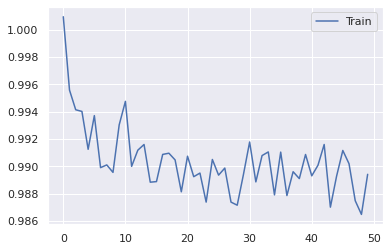

In [ ]:
# plot history
plt.plot(history.history['loss'], label='Train')
#plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [ ]:
# PERFORM PREDICTION
pred = model.predict(testX)

In [ ]:
trainy.shape

(1716, 1, 50)

In [ ]:
# PRINT PERFORMANCE METRICS
gtrue = testy.reshape(50, 430)
gpredicted = pred.reshape(50, 430)

mae_metr = mean_absolute_error(gtrue, gpredicted)
mape_metr = mean_absolute_percentage_error(gtrue, gpredicted)
mse_metr = mean_squared_error(gtrue, gpredicted)
rmse_metr = np.sqrt(mse_metr)
mase_metr = mean_absolute_scaled_error(gtrue, gpredicted, trainy.reshape(trainy.shape[0], trainy.shape[2]))

print("MAE  : ", mae_metr)
print("MAPE : ", mape_metr)
print("MSE  : ", mse_metr)
print("RMSE : ", rmse_metr)
print("MASE : ", mase_metr)
print("==============")



MAE  :  0.6693874076903933
MAPE :  0.9763711679741343
MSE  :  0.677716189008125
RMSE :  0.8232351966528916
MASE :  3.2667842181913835


In [ ]:
true = testy.reshape(430, 50) 
predicted = pred#.reshape(430, 50)

In [ ]:
true.shape, predicted.shape

((430, 50), (430, 50))

In [ ]:
# Feature metrics
ytrue = true
predicted = predicted#reshape(430, 50)[-1:].reshape(50, 1)
try:
    for i in range(len(ytrue)):
        mae_metr = mean_absolute_error(ytrue[i], predicted[i])
        mape_metr = mean_absolute_percentage_error(ytrue[i], predicted[i])
        mse_metr = mean_squared_error(ytrue[i], predicted[i])
        rmse_metr = np.sqrt(mse_metr)
        #mase_metr = mean_absolute_scaled_error(ytrue, predicted, decoder_target_data.reshape(50, 1))
        print(apn.columns[i])
        print("MAE  : ", mae_metr)
        print("MAPE : ", mape_metr)
        print("MSE  : ", mse_metr)
        print("RMSE : ", rmse_metr)
        #print("MASE : ", mase_metr)
        print("==============")
except IndexError:
    pass

APN_1
MAE  :  0.3385672671861635
MAPE :  1.0664513155411683
MSE  :  0.1712759067699933
RMSE :  0.41385493445166666
APN_2
MAE  :  0.2774041056662746
MAPE :  1.2541409521325415
MSE  :  0.11833044775116991
RMSE :  0.34399192977622295
APN_3
MAE  :  0.5770873267302071
MAPE :  0.7660537433256167
MSE  :  0.4201488280016965
RMSE :  0.6481888829667604
APN_4
MAE  :  0.7662701946951094
MAPE :  0.8064452185717467
MSE  :  0.753545014132012
RMSE :  0.8680697058024845
APN_5
MAE  :  0.7816931070076385
MAPE :  0.8143526950252731
MSE  :  0.7565680793678815
RMSE :  0.8698092200982245
APN_6
MAE  :  0.8763226672759523
MAPE :  0.8493695937191383
MSE  :  0.9434496516025637
RMSE :  0.9713133642664264
APN_7
MAE  :  0.7310735585736317
MAPE :  0.8298813136003325
MSE  :  0.6463161737648144
RMSE :  0.8039379166109871
APN_8
MAE  :  0.4171232028091885
MAPE :  0.7919491704189688
MSE  :  0.2505080335058382
RMSE :  0.5005077756697075
APN_9
MAE  :  0.32610616478495374
MAPE :  0.8311692338065005
MSE  :  0.193072229024268

### Training Test and prediction plots

In [ ]:
trainX.shape, trainy.shape

((1716, 14, 50), (1716, 1, 50))

In [ ]:
ytrue.shape, predicted.shape

((430, 50), (430, 50))

In [ ]:
tx = trainX.reshape(14, 1716, 50)[:1].reshape(1716, 1, 50).reshape(1716, 50)
ty = trainy.reshape(1716, 50)

In [ ]:
tsX = testX.reshape(14, 430, 50)[:1].reshape(430, 1, 50).reshape(430, 50)

In [ ]:
dates = apn.index
dates.shape

(2160,)

In [ ]:
tx.reshape(50, 1716)[1].shape

(1716,)

In [ ]:
def plothist(dates, train, test, predicted):
    for i in range(0, train.shape[1]):
        fig = plt.figure(figsize=(15, 4))
        fig.suptitle("Train, Test, and Forecast plots")
        past, = plt.plot(dates[:1716], train.reshape(50, 1716)[i], 'r.-', label="Train")
        future, = plt.plot(dates[1716:], test, color ='blue', label="Actual")
        predicted_future, = plt.plot(test.index, predicted, 'g.-', label="Predicted")
        plt.legend()
        plt.show()

In [ ]:
#plothist(dates, tx, tsX, predicted)

In [ ]:
 def forecast(data, model, period):
        curr_data = data
        past_14_hist = list(curr_data[-14:])
        predictions = []
        for p in range(0, period):
            past_14 = np.array(past_14_hist)
        
            #print(past_10)
            future = model.predict(past_14)
            predictions.append(future[0])
            past_14_hist.pop(0)
            past_14_hist.append(future)
        return np.array(predictions)

In [ ]:
def plot_forecasts(df):
    fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=False)
    axx = axs.ravel()
    for i in range(0, 10):
        df[df.columns[i]].loc[str(df.iloc[[0]].index[0]).split(' ')[0] : str(df.iloc[[len(df)-1]].index[0]).split(' ')[0]].plot(ax=axx[i])
        axx[i].set_xlabel("date")
        axx[i].set_ylabel(df.columns[i])  

# 7 Days Forecast

In [ ]:
f7 = forecast(testX, model, 168)

In [ ]:
f7 = scaler.inverse_transform(f7)

In [ ]:
cols = apn.columns

In [ ]:
f7d = pd.DataFrame(f7,columns=cols)

In [ ]:
f7d["Date"] = pd.date_range(start= '2021-04-01', periods=168, freq='1H')
f7d = f7d.set_index("Date")

In [ ]:
f7d.head()

,APN_1,APN_2,APN_3,APN_4,APN_5,APN_6,APN_7,APN_8,APN_9,APN_10,APN_11,APN_12,APN_13,APN_14,APN_15,APN_16,APN_17,APN_18,APN_19,APN_20,APN_21,APN_22,APN_23,APN_24,APN_25,APN_26,APN_27,APN_28,APN_29,APN_30,APN_31,APN_32,APN_33,APN_34,APN_35,APN_36,APN_37,APN_38,APN_39,APN_40,APN_41,APN_42,APN_43,APN_44,APN_45,APN_46,APN_47,APN_48,APN_49,APN_50
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-01 00:00:00,12.403865,5.351710,58.397491,67.237030,119.522865,105.414551,95.510757,76.926857,77.407906,77.063644,59.022110,138.915878,63.055149,78.050514,172.360397,54.983658,53.664368,61.589676,66.893517,57.957577,58.598015,59.208187,86.101418,114.424255,0.041751,0.162309,0.015313,0.060575,0.121117,0.158002,0.155766,0.151546,0.149999,0.163152,0.005110,0.141985,114.583557,99.683556,64.833382,47.376114,35.231636,47.522408,57.062988,52.228798,44.795040,51.549835,66.933121,83.367287,85.120438,77.264191
2021-04-01 01:00:00,12.470494,5.349528,58.735420,67.755486,120.146896,105.827522,96.061409,77.296425,77.583092,77.511734,59.291435,139.549957,63.349270,78.493088,172.979431,55.313545,53.983402,61.881519,67.317085,58.375267,58.951458,59.513218,86.613861,114.906204,0.041632,0.157908,0.016141,0.062183,0.121782,0.154659,0.156239,0.150085,0.147512,0.163215,0.005088,0.137486,115.165649,100.248787,65.267181,47.845348,35.587254,48.036068,57.636536,52.668564,45.281559,52.030666,67.501404,83.996567,85.796349,77.965385
2021-04-01 02:00:00,12.496357,5.372793,59.023258,68.047050,120.585747,106.243828,96.446709,77.613770,77.889709,77.791901,59.528236,140.177841,63.613785,78.761383,173.702301,55.578522,54.220814,62.162926,67.605385,58.624519,59.221283,59.782627,86.920975,115.339180,0.041910,0.157933,0.016562,0.063177,0.120378,0.154601,0.155394,0.151663,0.147981,0.163444,0.005082,0.137603,115.711037,100.638260,65.543762,47.972988,35.677280,48.147099,57.793045,52.797562,45.394810,52.147305,67.682198,84.228432,85.977661,78.213593
2021-04-01 03:00:00,12.490546,5.340882,58.916878,68.156120,120.406990,106.058990,96.371956,77.544174,77.596413,77.828369,59.413670,139.872192,63.591450,78.762741,173.195343,55.516808,54.130112,61.990971,67.474510,58.676926,59.147564,59.671211,86.899185,115.033363,0.041059,0.154329,0.017428,0.063225,0.121728,0.150495,0.156514,0.149682,0.143790,0.161608,0.005070,0.134044,115.492950,100.582878,65.526833,48.279438,35.955952,48.541264,58.158588,53.101658,45.747875,52.482956,67.970955,84.604195,86.405502,78.622261
2021-04-01 04:00:00,12.525550,5.342214,59.036320,68.292679,120.639290,106.162788,96.482773,77.612740,77.662888,77.922661,59.496666,139.961899,63.657970,78.866005,173.373398,55.598019,54.210514,62.068600,67.595688,58.773178,59.227680,59.735344,87.062973,115.169395,0.041090,0.153868,0.017020,0.062488,0.121354,0.149954,0.156931,0.147785,0.143167,0.161068,0.005064,0.133365,115.661819,100.688126,65.644775,48.377644,36.036777,48.648388,58.287251,53.219185,45.867836,52.622044,68.138054,84.748642,86.551331,78.777122


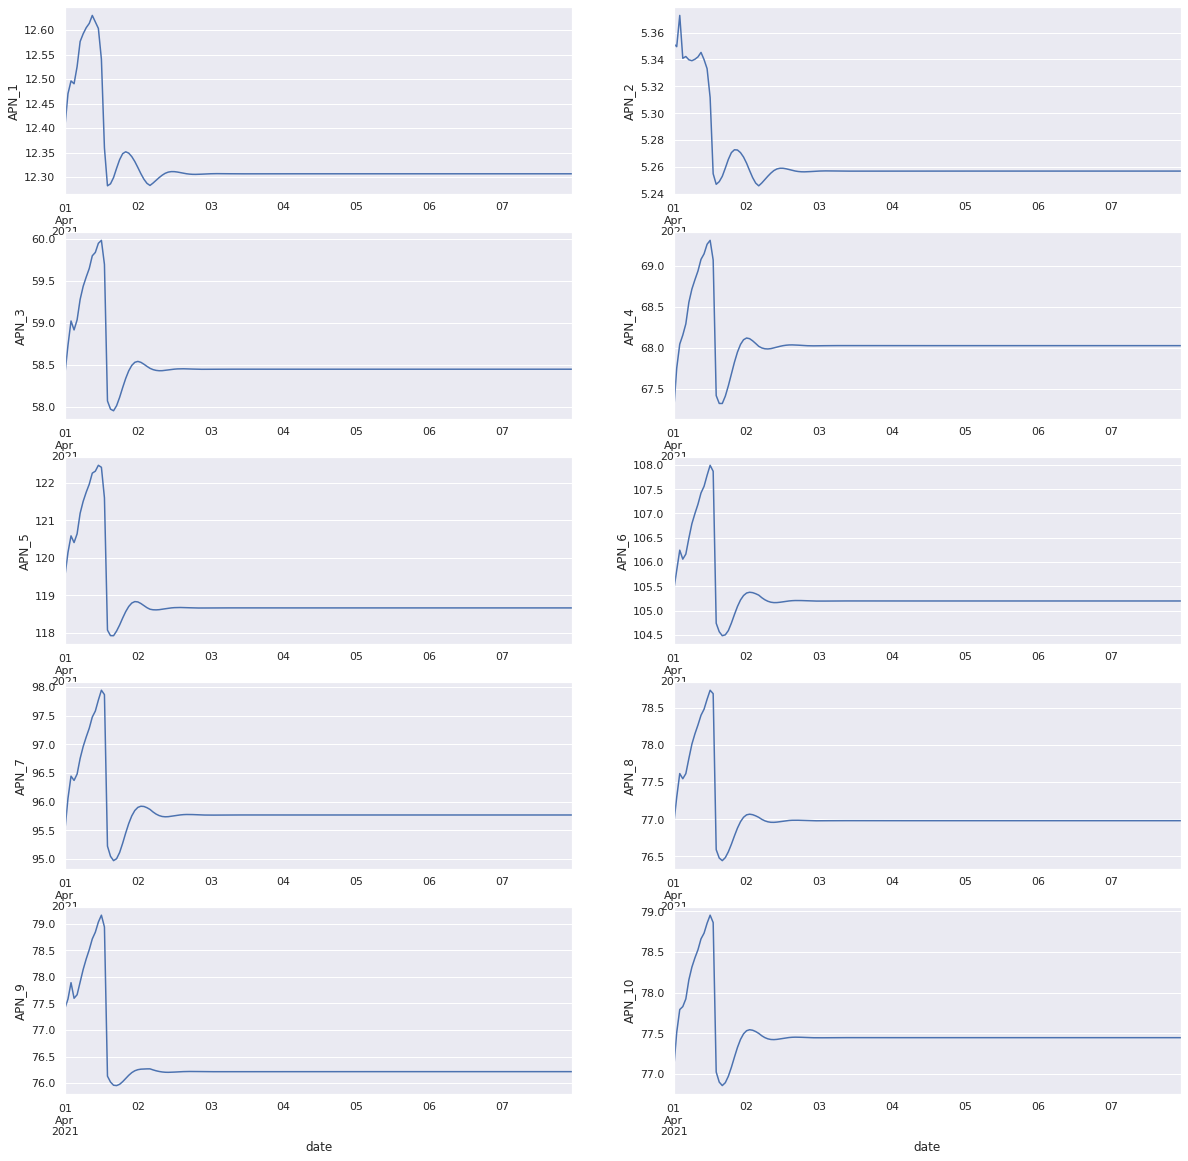

In [ ]:
plot_forecasts(f7d)

# 15 Days Forecast

In [ ]:
f15 = forecast(testX, model, 360)

In [ ]:
f15 = scaler.inverse_transform(f15)

In [ ]:
cols = apn.columns

In [ ]:
f15d = pd.DataFrame(f15,columns=cols)

In [ ]:
f15d["Date"] = pd.date_range(start= '2021-04-01', periods=360, freq='1H')
f15d = f15d.set_index("Date")

In [ ]:
f15d.head()

,APN_1,APN_2,APN_3,APN_4,APN_5,APN_6,APN_7,APN_8,APN_9,APN_10,APN_11,APN_12,APN_13,APN_14,APN_15,APN_16,APN_17,APN_18,APN_19,APN_20,APN_21,APN_22,APN_23,APN_24,APN_25,APN_26,APN_27,APN_28,APN_29,APN_30,APN_31,APN_32,APN_33,APN_34,APN_35,APN_36,APN_37,APN_38,APN_39,APN_40,APN_41,APN_42,APN_43,APN_44,APN_45,APN_46,APN_47,APN_48,APN_49,APN_50
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-01 00:00:00,12.403865,5.351710,58.397491,67.237030,119.522865,105.414551,95.510757,76.926857,77.407906,77.063644,59.022110,138.915878,63.055149,78.050514,172.360397,54.983658,53.664368,61.589676,66.893517,57.957577,58.598015,59.208187,86.101418,114.424255,0.041751,0.162309,0.015313,0.060575,0.121117,0.158002,0.155766,0.151546,0.149999,0.163152,0.005110,0.141985,114.583557,99.683556,64.833382,47.376114,35.231636,47.522408,57.062988,52.228798,44.795040,51.549835,66.933121,83.367287,85.120438,77.264191
2021-04-01 01:00:00,12.470494,5.349528,58.735420,67.755486,120.146896,105.827522,96.061409,77.296425,77.583092,77.511734,59.291435,139.549957,63.349270,78.493088,172.979431,55.313545,53.983402,61.881519,67.317085,58.375267,58.951458,59.513218,86.613861,114.906204,0.041632,0.157908,0.016141,0.062183,0.121782,0.154659,0.156239,0.150085,0.147512,0.163215,0.005088,0.137486,115.165649,100.248787,65.267181,47.845348,35.587254,48.036068,57.636536,52.668564,45.281559,52.030666,67.501404,83.996567,85.796349,77.965385
2021-04-01 02:00:00,12.496357,5.372793,59.023258,68.047050,120.585747,106.243828,96.446709,77.613770,77.889709,77.791901,59.528236,140.177841,63.613785,78.761383,173.702301,55.578522,54.220814,62.162926,67.605385,58.624519,59.221283,59.782627,86.920975,115.339180,0.041910,0.157933,0.016562,0.063177,0.120378,0.154601,0.155394,0.151663,0.147981,0.163444,0.005082,0.137603,115.711037,100.638260,65.543762,47.972988,35.677280,48.147099,57.793045,52.797562,45.394810,52.147305,67.682198,84.228432,85.977661,78.213593
2021-04-01 03:00:00,12.490546,5.340882,58.916878,68.156120,120.406990,106.058990,96.371956,77.544174,77.596413,77.828369,59.413670,139.872192,63.591450,78.762741,173.195343,55.516808,54.130112,61.990971,67.474510,58.676926,59.147564,59.671211,86.899185,115.033363,0.041059,0.154329,0.017428,0.063225,0.121728,0.150495,0.156514,0.149682,0.143790,0.161608,0.005070,0.134044,115.492950,100.582878,65.526833,48.279438,35.955952,48.541264,58.158588,53.101658,45.747875,52.482956,67.970955,84.604195,86.405502,78.622261
2021-04-01 04:00:00,12.525550,5.342214,59.036320,68.292679,120.639290,106.162788,96.482773,77.612740,77.662888,77.922661,59.496666,139.961899,63.657970,78.866005,173.373398,55.598019,54.210514,62.068600,67.595688,58.773178,59.227680,59.735344,87.062973,115.169395,0.041090,0.153868,0.017020,0.062488,0.121354,0.149954,0.156931,0.147785,0.143167,0.161068,0.005064,0.133365,115.661819,100.688126,65.644775,48.377644,36.036777,48.648388,58.287251,53.219185,45.867836,52.622044,68.138054,84.748642,86.551331,78.777122


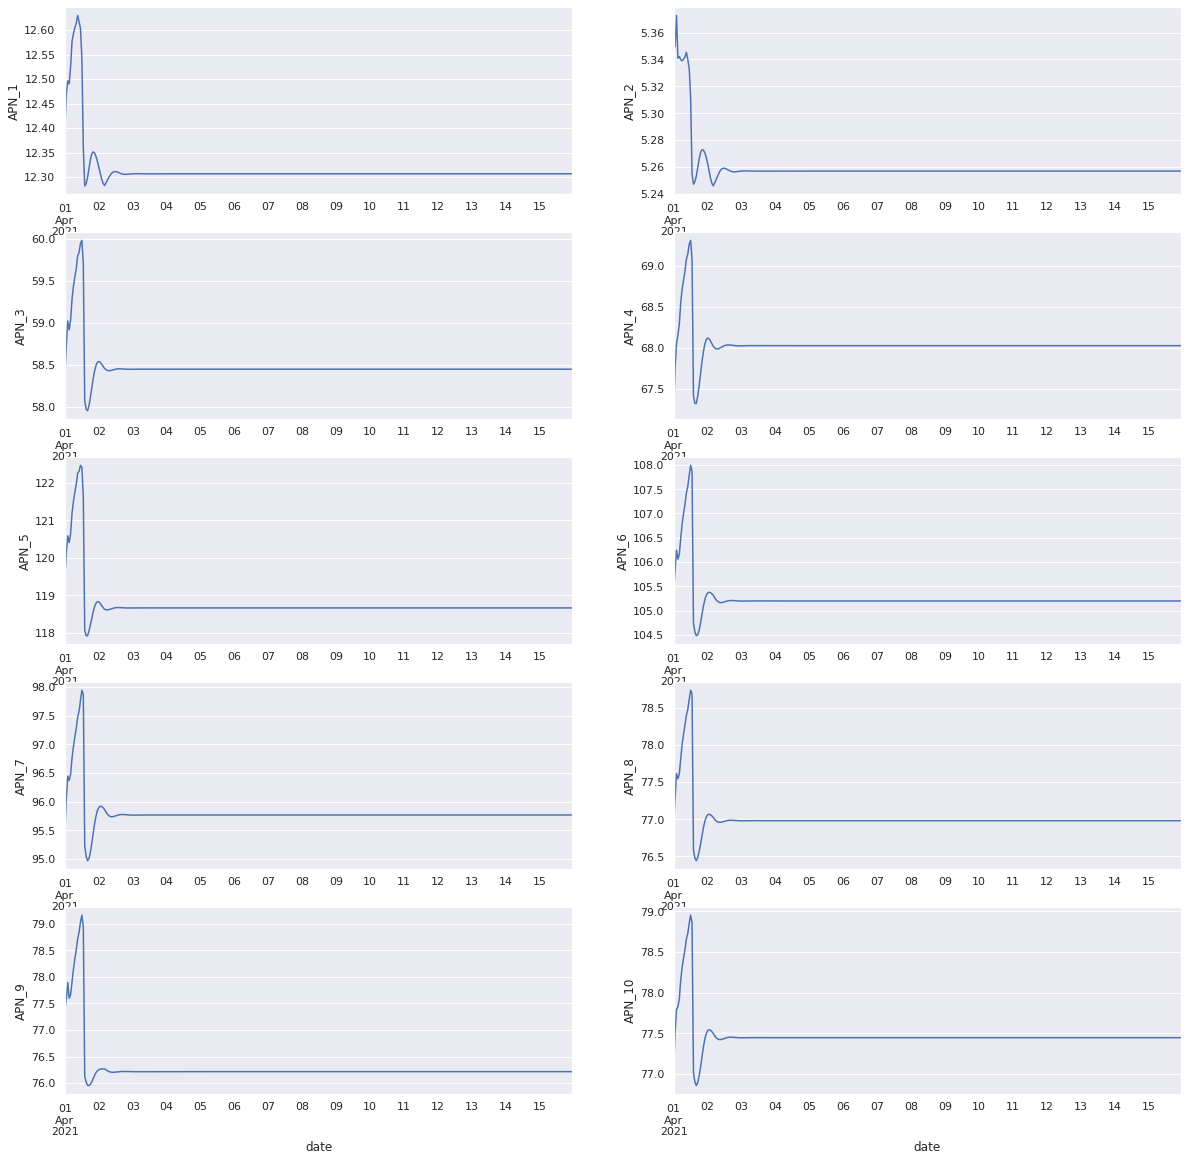

In [ ]:
plot_forecasts(f15d)

# One Month Forecast

In [ ]:
f1 = forecast(testX, model, 720)

In [ ]:
f1 = scaler.inverse_transform(f1)

In [ ]:
cols = apn.columns

In [ ]:
f1m = pd.DataFrame(f1,columns=cols)

In [ ]:
f1m["Date"] = pd.date_range(start= '2021-04-01', periods=720, freq='1H')
f1m = f1m.set_index("Date")

In [ ]:
f1m.head()

,APN_1,APN_2,APN_3,APN_4,APN_5,APN_6,APN_7,APN_8,APN_9,APN_10,APN_11,APN_12,APN_13,APN_14,APN_15,APN_16,APN_17,APN_18,APN_19,APN_20,APN_21,APN_22,APN_23,APN_24,APN_25,APN_26,APN_27,APN_28,APN_29,APN_30,APN_31,APN_32,APN_33,APN_34,APN_35,APN_36,APN_37,APN_38,APN_39,APN_40,APN_41,APN_42,APN_43,APN_44,APN_45,APN_46,APN_47,APN_48,APN_49,APN_50
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-01 00:00:00,12.403865,5.351710,58.397491,67.237030,119.522865,105.414551,95.510757,76.926857,77.407906,77.063644,59.022110,138.915878,63.055149,78.050514,172.360397,54.983658,53.664368,61.589676,66.893517,57.957577,58.598015,59.208187,86.101418,114.424255,0.041751,0.162309,0.015313,0.060575,0.121117,0.158002,0.155766,0.151546,0.149999,0.163152,0.005110,0.141985,114.583557,99.683556,64.833382,47.376114,35.231636,47.522408,57.062988,52.228798,44.795040,51.549835,66.933121,83.367287,85.120438,77.264191
2021-04-01 01:00:00,12.470494,5.349528,58.735420,67.755486,120.146896,105.827522,96.061409,77.296425,77.583092,77.511734,59.291435,139.549957,63.349270,78.493088,172.979431,55.313545,53.983402,61.881519,67.317085,58.375267,58.951458,59.513218,86.613861,114.906204,0.041632,0.157908,0.016141,0.062183,0.121782,0.154659,0.156239,0.150085,0.147512,0.163215,0.005088,0.137486,115.165649,100.248787,65.267181,47.845348,35.587254,48.036068,57.636536,52.668564,45.281559,52.030666,67.501404,83.996567,85.796349,77.965385
2021-04-01 02:00:00,12.496357,5.372793,59.023258,68.047050,120.585747,106.243828,96.446709,77.613770,77.889709,77.791901,59.528236,140.177841,63.613785,78.761383,173.702301,55.578522,54.220814,62.162926,67.605385,58.624519,59.221283,59.782627,86.920975,115.339180,0.041910,0.157933,0.016562,0.063177,0.120378,0.154601,0.155394,0.151663,0.147981,0.163444,0.005082,0.137603,115.711037,100.638260,65.543762,47.972988,35.677280,48.147099,57.793045,52.797562,45.394810,52.147305,67.682198,84.228432,85.977661,78.213593
2021-04-01 03:00:00,12.490546,5.340882,58.916878,68.156120,120.406990,106.058990,96.371956,77.544174,77.596413,77.828369,59.413670,139.872192,63.591450,78.762741,173.195343,55.516808,54.130112,61.990971,67.474510,58.676926,59.147564,59.671211,86.899185,115.033363,0.041059,0.154329,0.017428,0.063225,0.121728,0.150495,0.156514,0.149682,0.143790,0.161608,0.005070,0.134044,115.492950,100.582878,65.526833,48.279438,35.955952,48.541264,58.158588,53.101658,45.747875,52.482956,67.970955,84.604195,86.405502,78.622261
2021-04-01 04:00:00,12.525550,5.342214,59.036320,68.292679,120.639290,106.162788,96.482773,77.612740,77.662888,77.922661,59.496666,139.961899,63.657970,78.866005,173.373398,55.598019,54.210514,62.068600,67.595688,58.773178,59.227680,59.735344,87.062973,115.169395,0.041090,0.153868,0.017020,0.062488,0.121354,0.149954,0.156931,0.147785,0.143167,0.161068,0.005064,0.133365,115.661819,100.688126,65.644775,48.377644,36.036777,48.648388,58.287251,53.219185,45.867836,52.622044,68.138054,84.748642,86.551331,78.777122


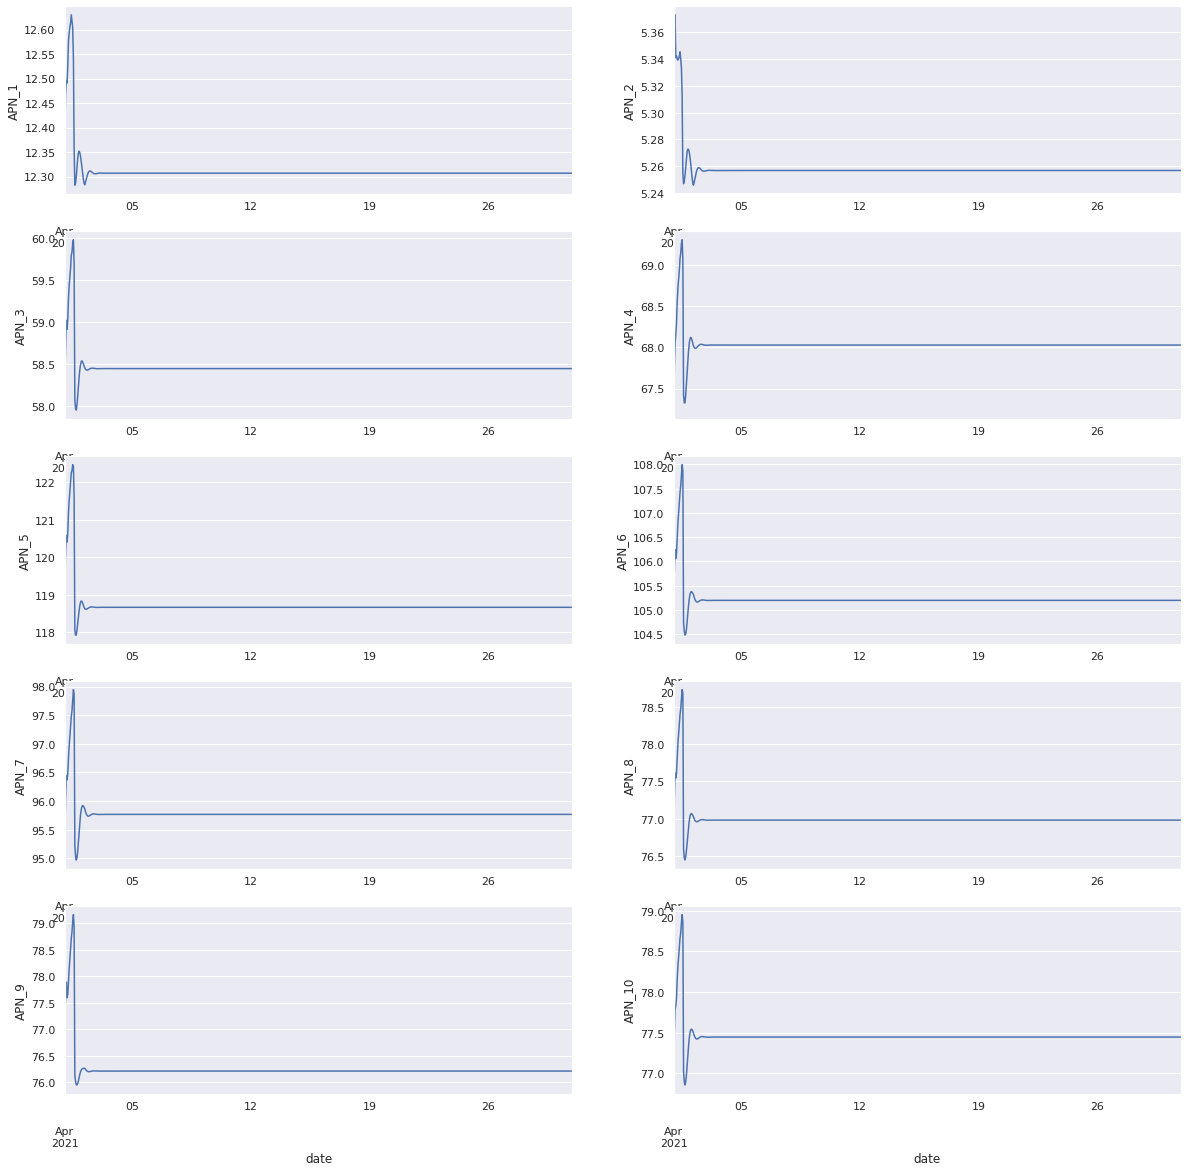

In [ ]:
plot_forecasts(f1m)

#### TRAIN TEST PLOTS

In [ ]:
trainX.shape, testX.shape

((1716, 14, 50), (430, 14, 50))

# NBEATS

In [ ]:
import warnings
import numpy as np
from nbeats_keras.model import NBeatsNet as NBeatsKeras

In [ ]:
warnings.filterwarnings(action='ignore', message='Setting attribute')

In [ ]:
trainX.shape

(1716, 14, 50)

In [ ]:
def forecast(testX, model, period):
    curr_data = testX
    past_14_hist = None
    predictions = []
    for p in range(0, period):
        if p == 0:
            past_14_hist = curr_data[-1:]
            #print(past_14.shape)
        future = model.predict(past_14_hist.reshape(50, 14, 1))
        predictions.append(future[-1:].reshape(1, 50))
        #temp = past_14_hist
        past_14_hist = future[36:] #np.append(temp, future[0].reshape(1, 50), axis=1)
        
        #past_14_hist = future.reshape(1, 14, 50)
    preds = np.array(predictions).reshape(period, 50)
    return preds

In [ ]:
def main():
    warnings.filterwarnings(action='ignore')
    num_samples, time_steps, input_dim, output_dim = trainX.shape[0], trainX.shape[1], trainX.shape[2], trainX.shape[2] 
    backend = NBeatsKeras(
                    backcast_length=time_steps, forecast_length=output_dim,
                    stack_types=(NBeatsKeras.GENERIC_BLOCK, NBeatsKeras.GENERIC_BLOCK),
                    nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
                    hidden_layer_units=128)
    
    backend.compile(loss='mae', optimizer='adam')
    backend.fit(trainX, trainy, epochs=30, batch_size=64, verbose=False)
    preds = backend.predict(testX).reshape(430, 1, 50)
    
    mae = mean_absolute_error(testy[0], preds[0])
    mape = mean_absolute_percentage_error(testy[0], preds[0])
    mse = mean_squared_error(testy[0], preds[0])
    rmse = np.sqrt(mse)
    mase = mean_absolute_scaled_error(testy[0], preds[0], trainy.reshape(1716, 50))
    
    print("\n\n")
    print("Global Metrics : ")
    print("MAE  : ", mae)
    print("MAPE : ", mape)
    print("MSE  : ", mse)
    print("RMSE : ", rmse)
    print("MASE : ", mase)
    
    print("==============")
    
    try:
        print("Feature Metrics : ")
        for i in range(0, len(testy)):
            mae = mean_absolute_error(testy[i], preds[i])
            mape = mean_absolute_percentage_error(testy[i], preds[i])
            mse = mean_squared_error(testy[i], preds[i])
            rmse = np.sqrt(mse)
            mase = mean_absolute_scaled_error(testy[i], preds[i], trainy.reshape(1716, 50))

            print(apn.columns[i])
            print("MAE  : ", mae)
            print("MAPE : ", mape)
            print("MSE  : ", mse)
            print("RMSE : ", rmse)
            print("MASE : ", mase)
    except IndexError as e:
        pass
        
    
    
    print("Executing 7 Days forecast ...")
    f7 = forecast(testX, backend, 168)
    print("Executing 15 Days forecast ...")
    f15 = forecast(testX, backend, 360)
    print("Executing 1 month forecast ...")
    f1 = forecast(testX, backend, 720)
    inv_f7 = scaler.inverse_transform(f7)
    inv_f15 = scaler.inverse_transform(f15)
    inv_f1 = scaler.inverse_transform(f1)
    
    f7 = pd.DataFrame(inv_f7, columns=df.columns)
    f7["Date"] = pd.date_range(start= '2021-04-01', periods=168, freq='1H')
    f7 = f7.set_index("Date")
    f15 = pd.DataFrame(inv_f15, columns=df.columns)
    f15["Date"] = pd.date_range(start= '2021-04-01', periods=360, freq='1H')
    f15 = f15.set_index("Date")
    f1 = pd.DataFrame(inv_f1, columns=df.columns)
    f1["Date"] = pd.date_range(start= '2021-04-01', periods=720, freq='1H')
    f1 = f1.set_index("Date")
    
    
    return f7, f15, f1

In [ ]:
trainy.shape

(1716, 1, 50)

In [ ]:
f7, f15, f1 = main()




Global Metrics : 
MAE  :  0.34531258414716215
MAPE :  1.0235980469519372
MSE  :  0.17750729725980655
RMSE :  0.4213161488239046
MASE :  1.6852149999758992
Feature Metrics : 
APN_1
MAE  :  0.34531258414716215
MAPE :  1.0235980469519372
MSE  :  0.17750729725980655
RMSE :  0.4213161488239046
MASE :  1.6852149999758992
APN_2
MAE  :  0.2196849816201122
MAPE :  2.152448489126826
MSE  :  0.07209266547675412
RMSE :  0.26850077369861364
MASE :  1.0721197062944787
APN_3
MAE  :  0.31719633940784253
MAPE :  1.0664418992266298
MSE  :  0.1608875086813072
RMSE :  0.4011078516824461
MASE :  1.5480004310521616
APN_4
MAE  :  0.4413977809147205
MAPE :  1.5421602962199714
MSE  :  0.3415880775038838
RMSE :  0.5844553682736465
MASE :  2.154135688945977
APN_5
MAE  :  0.387341819944629
MAPE :  1.4805671784898047
MSE  :  0.31282692747429186
RMSE :  0.559309330759189
MASE :  1.8903285749078529
APN_6
MAE  :  0.3987057978845588
MAPE :  1.5447952942455396
MSE  :  0.34573143469290046
RMSE :  0.5879893151179709
M

## 7 Days Forecast

In [ ]:
f7.head()

,APN_1,APN_2,APN_3,APN_4,APN_5,APN_6,APN_7,APN_8,APN_9,APN_10,APN_11,APN_12,APN_13,APN_14,APN_15,APN_16,APN_17,APN_18,APN_19,APN_20,APN_21,APN_22,APN_23,APN_24,APN_25,APN_26,APN_27,APN_28,APN_29,APN_30,APN_31,APN_32,APN_33,APN_34,APN_35,APN_36,APN_37,APN_38,APN_39,APN_40,APN_41,APN_42,APN_43,APN_44,APN_45,APN_46,APN_47,APN_48,APN_49,APN_50
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-01 00:00:00,15.503644,7.764230,69.985008,80.627129,140.283173,126.837708,111.228821,86.654610,91.546898,91.013535,69.687012,162.360062,71.738052,92.590576,196.590973,64.705925,65.221832,74.937729,80.150040,70.064323,69.487595,72.050529,101.717545,137.904785,0.058740,0.442850,0.261207,0.525897,0.518826,0.645181,0.752725,0.543308,0.654091,0.652023,0.023894,0.569274,135.149551,114.051285,76.030685,53.893112,43.985916,54.181007,67.788498,59.392334,52.071907,60.395420,78.555275,95.958298,97.032990,94.163803
2021-04-01 01:00:00,14.721078,7.835238,71.555161,81.312965,145.541641,125.765808,113.456963,91.400131,94.220932,91.837242,69.919853,163.548676,75.265678,92.253532,203.508621,68.618134,66.869896,75.904350,82.177628,70.465103,71.280975,71.361107,104.465080,138.104889,0.057329,0.707237,0.330485,0.505576,0.618581,0.740554,0.611690,0.640690,0.607338,0.685193,0.022470,0.612832,138.436050,118.353889,78.782799,56.811283,42.520893,56.943272,67.121460,61.404232,53.811008,59.374729,78.617821,97.116714,97.946304,95.273880
2021-04-01 02:00:00,15.030603,7.919374,71.655678,82.024612,145.252060,126.758492,113.743790,91.076195,94.344170,92.308479,70.340614,164.258392,74.948769,92.994972,203.524780,68.343124,66.909584,76.355728,82.406715,71.154648,71.348579,72.199425,104.735519,139.048737,0.058503,0.674467,0.327285,0.527075,0.610957,0.745420,0.669924,0.644796,0.641253,0.698818,0.023867,0.620445,138.730499,118.307259,78.851311,56.496910,43.118851,56.715843,67.706299,61.421329,53.850510,60.099789,79.220253,97.292183,98.269775,95.719833
2021-04-01 03:00:00,14.983530,7.923615,71.687660,81.961182,145.388794,126.670639,113.762886,91.171173,94.414124,92.287277,70.306297,164.254562,75.067566,92.939957,203.624146,68.434929,66.988960,76.318756,82.477295,71.064888,71.404259,72.111412,104.784470,138.951553,0.058351,0.683035,0.329482,0.525501,0.615021,0.747226,0.662672,0.645781,0.636891,0.698770,0.023681,0.622521,138.876740,118.416306,78.909470,56.581493,43.049706,56.804070,67.624397,61.460423,53.859268,60.007378,79.169579,97.324539,98.239693,95.700890
2021-04-01 04:00:00,14.992925,7.922139,71.671173,81.967392,145.343674,126.683006,113.747063,91.139580,94.393265,92.286720,70.307404,164.246338,75.034691,92.946327,203.576401,68.406723,66.969292,76.318680,82.456665,71.074524,71.388481,72.124184,104.764267,138.963120,0.058375,0.680746,0.328888,0.525674,0.614008,0.746492,0.664084,0.645231,0.637630,0.698575,0.023710,0.622027,138.836853,118.384529,78.890511,56.557880,43.064346,56.781334,67.638031,61.447067,53.850761,60.023079,79.177200,97.312805,98.239815,95.699196


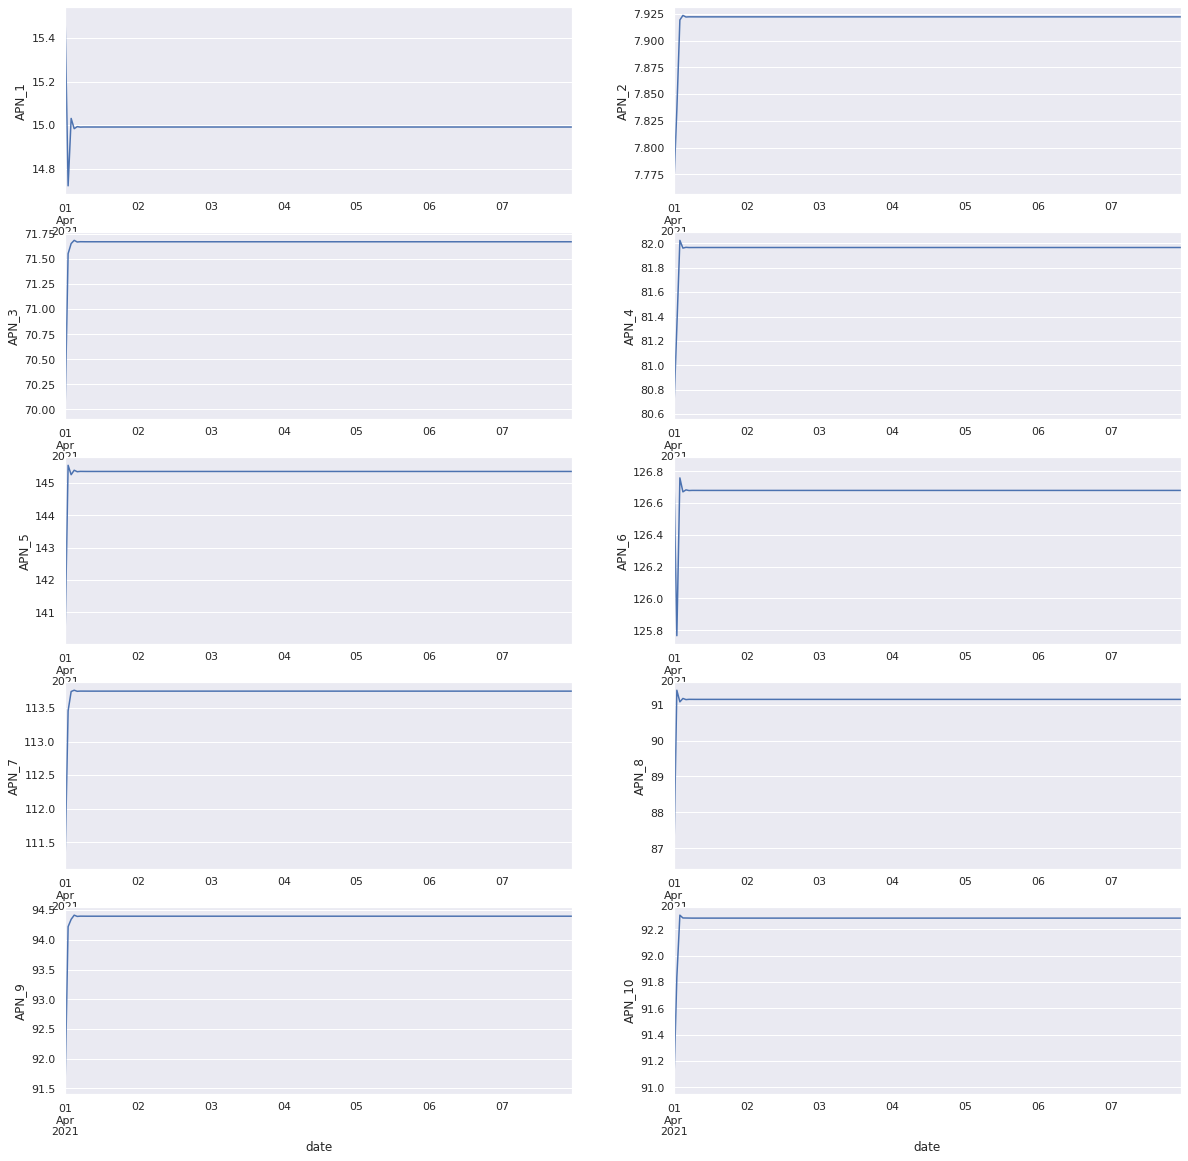

In [ ]:
plot_forecasts(f7)

# 15 Days Forecast

In [ ]:
f15.head()

,APN_1,APN_2,APN_3,APN_4,APN_5,APN_6,APN_7,APN_8,APN_9,APN_10,APN_11,APN_12,APN_13,APN_14,APN_15,APN_16,APN_17,APN_18,APN_19,APN_20,APN_21,APN_22,APN_23,APN_24,APN_25,APN_26,APN_27,APN_28,APN_29,APN_30,APN_31,APN_32,APN_33,APN_34,APN_35,APN_36,APN_37,APN_38,APN_39,APN_40,APN_41,APN_42,APN_43,APN_44,APN_45,APN_46,APN_47,APN_48,APN_49,APN_50
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-01 00:00:00,15.503644,7.764230,69.985008,80.627129,140.283173,126.837708,111.228821,86.654610,91.546898,91.013535,69.687012,162.360062,71.738052,92.590576,196.590973,64.705925,65.221832,74.937729,80.150040,70.064323,69.487595,72.050529,101.717545,137.904785,0.058740,0.442850,0.261207,0.525897,0.518826,0.645181,0.752725,0.543308,0.654091,0.652023,0.023894,0.569274,135.149551,114.051285,76.030685,53.893112,43.985916,54.181007,67.788498,59.392334,52.071907,60.395420,78.555275,95.958298,97.032990,94.163803
2021-04-01 01:00:00,14.721078,7.835238,71.555161,81.312965,145.541641,125.765808,113.456963,91.400131,94.220932,91.837242,69.919853,163.548676,75.265678,92.253532,203.508621,68.618134,66.869896,75.904350,82.177628,70.465103,71.280975,71.361107,104.465080,138.104889,0.057329,0.707237,0.330485,0.505576,0.618581,0.740554,0.611690,0.640690,0.607338,0.685193,0.022470,0.612832,138.436050,118.353889,78.782799,56.811283,42.520893,56.943272,67.121460,61.404232,53.811008,59.374729,78.617821,97.116714,97.946304,95.273880
2021-04-01 02:00:00,15.030603,7.919374,71.655678,82.024612,145.252060,126.758492,113.743790,91.076195,94.344170,92.308479,70.340614,164.258392,74.948769,92.994972,203.524780,68.343124,66.909584,76.355728,82.406715,71.154648,71.348579,72.199425,104.735519,139.048737,0.058503,0.674467,0.327285,0.527075,0.610957,0.745420,0.669924,0.644796,0.641253,0.698818,0.023867,0.620445,138.730499,118.307259,78.851311,56.496910,43.118851,56.715843,67.706299,61.421329,53.850510,60.099789,79.220253,97.292183,98.269775,95.719833
2021-04-01 03:00:00,14.983530,7.923615,71.687660,81.961182,145.388794,126.670639,113.762886,91.171173,94.414124,92.287277,70.306297,164.254562,75.067566,92.939957,203.624146,68.434929,66.988960,76.318756,82.477295,71.064888,71.404259,72.111412,104.784470,138.951553,0.058351,0.683035,0.329482,0.525501,0.615021,0.747226,0.662672,0.645781,0.636891,0.698770,0.023681,0.622521,138.876740,118.416306,78.909470,56.581493,43.049706,56.804070,67.624397,61.460423,53.859268,60.007378,79.169579,97.324539,98.239693,95.700890
2021-04-01 04:00:00,14.992925,7.922139,71.671173,81.967392,145.343674,126.683006,113.747063,91.139580,94.393265,92.286720,70.307404,164.246338,75.034691,92.946327,203.576401,68.406723,66.969292,76.318680,82.456665,71.074524,71.388481,72.124184,104.764267,138.963120,0.058375,0.680746,0.328888,0.525674,0.614008,0.746492,0.664084,0.645231,0.637630,0.698575,0.023710,0.622027,138.836853,118.384529,78.890511,56.557880,43.064346,56.781334,67.638031,61.447067,53.850761,60.023079,79.177200,97.312805,98.239815,95.699196


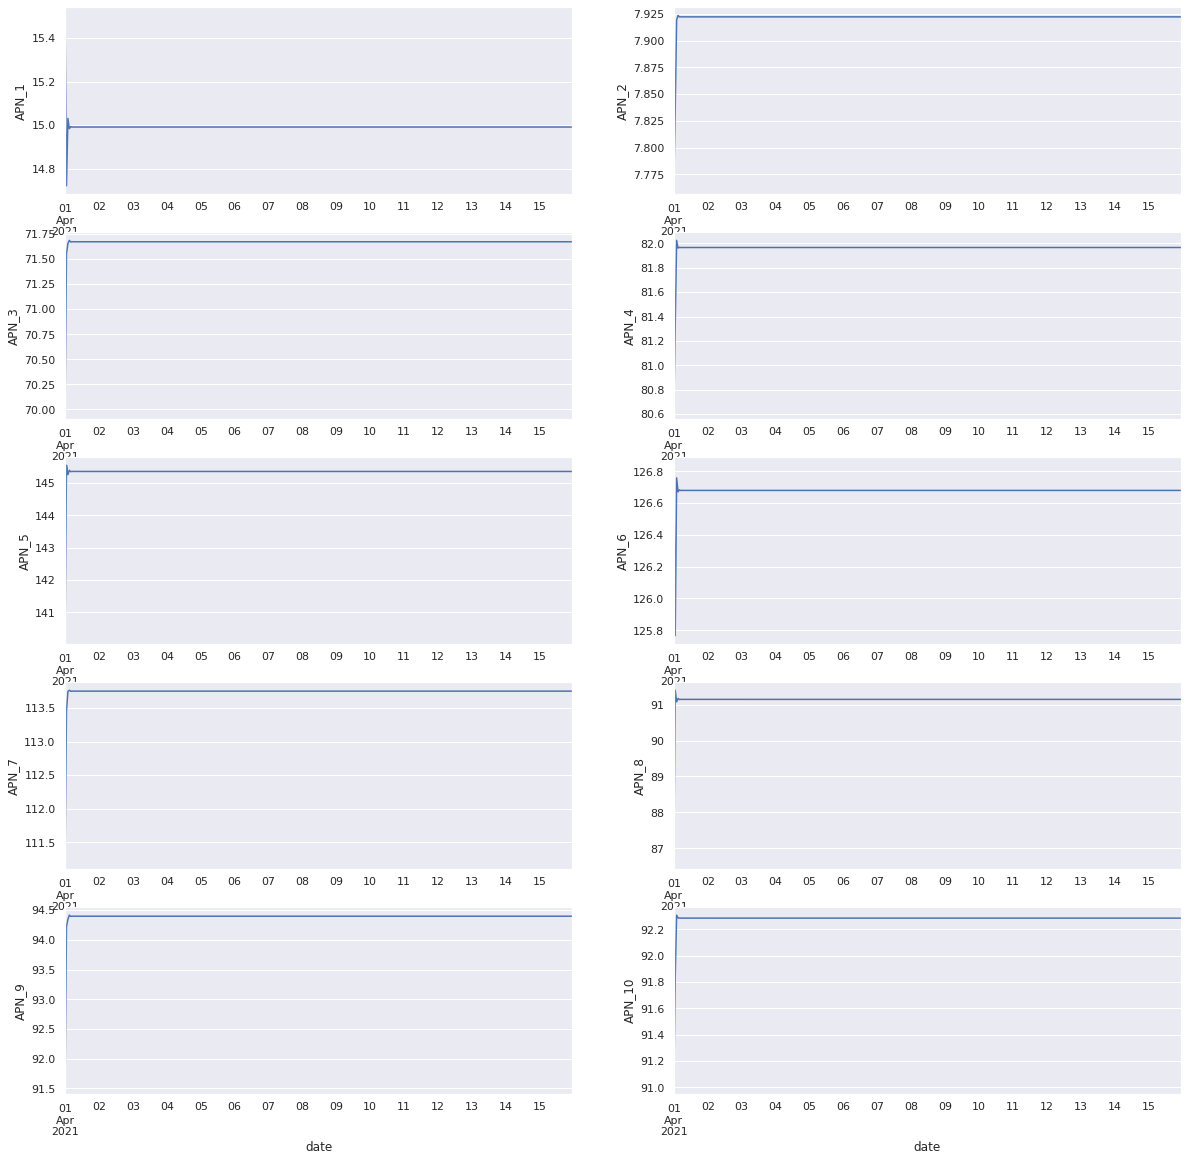

In [ ]:
plot_forecasts(f15)

# One Month Forecast

In [ ]:
f1.head()

,APN_1,APN_2,APN_3,APN_4,APN_5,APN_6,APN_7,APN_8,APN_9,APN_10,APN_11,APN_12,APN_13,APN_14,APN_15,APN_16,APN_17,APN_18,APN_19,APN_20,APN_21,APN_22,APN_23,APN_24,APN_25,APN_26,APN_27,APN_28,APN_29,APN_30,APN_31,APN_32,APN_33,APN_34,APN_35,APN_36,APN_37,APN_38,APN_39,APN_40,APN_41,APN_42,APN_43,APN_44,APN_45,APN_46,APN_47,APN_48,APN_49,APN_50
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-01 00:00:00,15.503644,7.764230,69.985008,80.627129,140.283173,126.837708,111.228821,86.654610,91.546898,91.013535,69.687012,162.360062,71.738052,92.590576,196.590973,64.705925,65.221832,74.937729,80.150040,70.064323,69.487595,72.050529,101.717545,137.904785,0.058740,0.442850,0.261207,0.525897,0.518826,0.645181,0.752725,0.543308,0.654091,0.652023,0.023894,0.569274,135.149551,114.051285,76.030685,53.893112,43.985916,54.181007,67.788498,59.392334,52.071907,60.395420,78.555275,95.958298,97.032990,94.163803
2021-04-01 01:00:00,14.721078,7.835238,71.555161,81.312965,145.541641,125.765808,113.456963,91.400131,94.220932,91.837242,69.919853,163.548676,75.265678,92.253532,203.508621,68.618134,66.869896,75.904350,82.177628,70.465103,71.280975,71.361107,104.465080,138.104889,0.057329,0.707237,0.330485,0.505576,0.618581,0.740554,0.611690,0.640690,0.607338,0.685193,0.022470,0.612832,138.436050,118.353889,78.782799,56.811283,42.520893,56.943272,67.121460,61.404232,53.811008,59.374729,78.617821,97.116714,97.946304,95.273880
2021-04-01 02:00:00,15.030603,7.919374,71.655678,82.024612,145.252060,126.758492,113.743790,91.076195,94.344170,92.308479,70.340614,164.258392,74.948769,92.994972,203.524780,68.343124,66.909584,76.355728,82.406715,71.154648,71.348579,72.199425,104.735519,139.048737,0.058503,0.674467,0.327285,0.527075,0.610957,0.745420,0.669924,0.644796,0.641253,0.698818,0.023867,0.620445,138.730499,118.307259,78.851311,56.496910,43.118851,56.715843,67.706299,61.421329,53.850510,60.099789,79.220253,97.292183,98.269775,95.719833
2021-04-01 03:00:00,14.983530,7.923615,71.687660,81.961182,145.388794,126.670639,113.762886,91.171173,94.414124,92.287277,70.306297,164.254562,75.067566,92.939957,203.624146,68.434929,66.988960,76.318756,82.477295,71.064888,71.404259,72.111412,104.784470,138.951553,0.058351,0.683035,0.329482,0.525501,0.615021,0.747226,0.662672,0.645781,0.636891,0.698770,0.023681,0.622521,138.876740,118.416306,78.909470,56.581493,43.049706,56.804070,67.624397,61.460423,53.859268,60.007378,79.169579,97.324539,98.239693,95.700890
2021-04-01 04:00:00,14.992925,7.922139,71.671173,81.967392,145.343674,126.683006,113.747063,91.139580,94.393265,92.286720,70.307404,164.246338,75.034691,92.946327,203.576401,68.406723,66.969292,76.318680,82.456665,71.074524,71.388481,72.124184,104.764267,138.963120,0.058375,0.680746,0.328888,0.525674,0.614008,0.746492,0.664084,0.645231,0.637630,0.698575,0.023710,0.622027,138.836853,118.384529,78.890511,56.557880,43.064346,56.781334,67.638031,61.447067,53.850761,60.023079,79.177200,97.312805,98.239815,95.699196


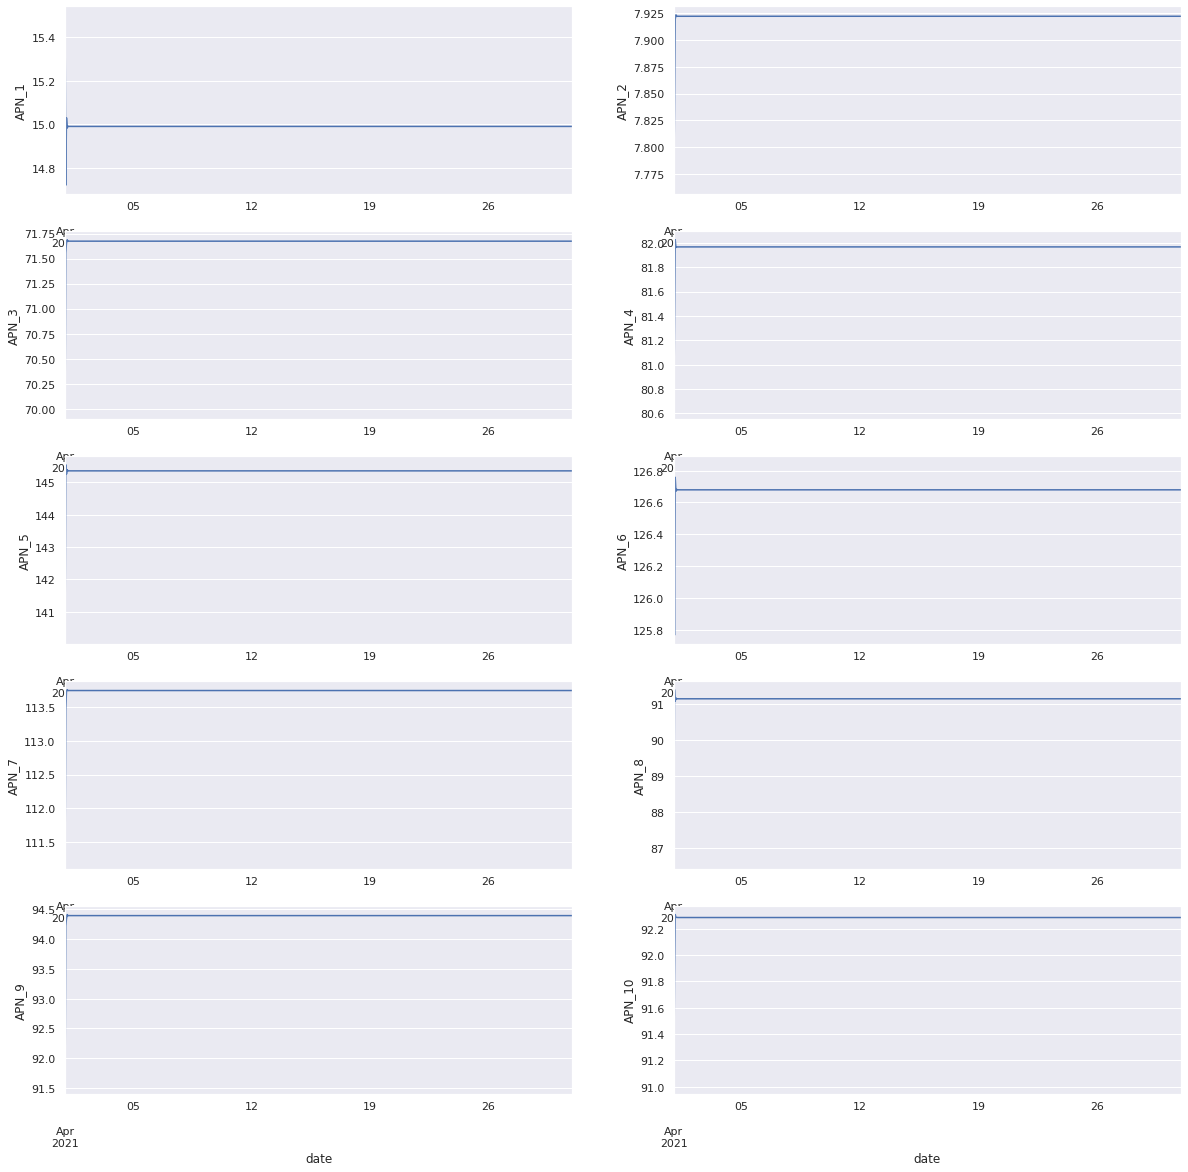

In [ ]:
plot_forecasts(f1)

# CNN(Wavenet)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
pd.set_option("display.max_columns", 800)

data = pd.read_csv('./apn_utilization_hourly_3months_50nodes.csv')
data.drop('Unnamed: 1', axis=1, inplace=True)
data.head()

,Unnamed: 0,"1/01/21, 00:00","1/01/21, 01:00","1/01/21, 02:00","1/01/21, 03:00","1/01/21, 04:00","1/01/21, 05:00","1/01/21, 06:00","1/01/21, 07:00","1/01/21, 08:00","1/01/21, 09:00","1/01/21, 10:00","1/01/21, 11:00","1/01/21, 12:00","1/01/21, 13:00","1/01/21, 14:00","1/01/21, 15:00","1/01/21, 16:00","1/01/21, 17:00","1/01/21, 18:00","1/01/21, 19:00","1/01/21, 20:00","1/01/21, 21:00","1/01/21, 22:00","1/01/21, 23:00","2/01/21, 00:00","2/01/21, 01:00","2/01/21, 02:00","2/01/21, 03:00","2/01/21, 04:00","2/01/21, 05:00","2/01/21, 06:00","2/01/21, 07:00","2/01/21, 08:00","2/01/21, 09:00","2/01/21, 10:00","2/01/21, 11:00","2/01/21, 12:00","2/01/21, 13:00","2/01/21, 14:00","2/01/21, 15:00","2/01/21, 16:00","2/01/21, 17:00","2/01/21, 18:00","2/01/21, 19:00","2/01/21, 20:00","2/01/21, 21:00","2/01/21, 22:00","2/01/21, 23:00","3/01/21, 00:00","3/01/21, 01:00","3/01/21, 02:00","3/01/21, 03:00","3/01/21, 04:00","3/01/21, 05:00","3/01/21, 06:00","3/01/21, 07:00","3/01/21, 08:00","3/01/21, 09:00","3/01/21, 10:00","3/01/21, 11:00","3/01/21, 12:00","3/01/21, 13:00","3/01/21, 14:00","3/01/21, 15:00","3/01/21, 16:00","3/01/21, 17:00","3/01/21, 18:00","3/01/21, 19:00","3/01/21, 20:00","3/01/21, 21:00","3/01/21, 22:00","3/01/21, 23:00","4/01/21, 00:00","4/01/21, 01:00","4/01/21, 02:00","4/01/21, 03:00","4/01/21, 04:00","4/01/21, 05:00","4/01/21, 06:00","4/01/21, 07:00","4/01/21, 08:00","4/01/21, 09:00","4/01/21, 10:00","4/01/21, 11:00","4/01/21, 12:00","4/01/21, 13:00","4/01/21, 14:00","4/01/21, 15:00","4/01/21, 16:00","4/01/21, 17:00","4/01/21, 18:00","4/01/21, 19:00","4/01/21, 20:00","4/01/21, 21:00","4/01/21, 22:00","4/01/21, 23:00","5/01/21, 00:00","5/01/21, 01:00","5/01/21, 02:00","5/01/21, 03:00","5/01/21, 04:00","5/01/21, 05:00","5/01/21, 06:00","5/01/21, 07:00","5/01/21, 08:00","5/01/21, 09:00","5/01/21, 10:00","5/01/21, 11:00","5/01/21, 12:00","5/01/21, 13:00","5/01/21, 14:00","5/01/21, 15:00","5/01/21, 16:00","5/01/21, 17:00","5/01/21, 18:00","5/01/21, 19:00","5/01/21, 20:00","5/01/21, 21:00","5/01/21, 22:00","5/01/21, 23:00","6/01/21, 00:00","6/01/21, 01:00","6/01/21, 02:00","6/01/21, 03:00","6/01/21, 04:00","6/01/21, 05:00","6/01/21, 06:00","6/01/21, 07:00","6/01/21, 08:00","6/01/21, 09:00","6/01/21, 10:00","6/01/21, 11:00","6/01/21, 12:00","6/01/21, 13:00","6/01/21, 14:00","6/01/21, 15:00","6/01/21, 16:00","6/01/21, 17:00","6/01/21, 18:00","6/01/21, 19:00","6/01/21, 20:00","6/01/21, 21:00","6/01/21, 22:00","6/01/21, 23:00","7/01/21, 00:00","7/01/21, 01:00","7/01/21, 02:00","7/01/21, 03:00","7/01/21, 04:00","7/01/21, 05:00","7/01/21, 06:00","7/01/21, 07:00","7/01/21, 08:00","7/01/21, 09:00","7/01/21, 10:00","7/01/21, 11:00","7/01/21, 12:00","7/01/21, 13:00","7/01/21, 14:00","7/01/21, 15:00","7/01/21, 16:00","7/01/21, 17:00","7/01/21, 18:00","7/01/21, 19:00","7/01/21, 20:00","7/01/21, 21:00","7/01/21, 22:00","7/01/21, 23:00","8/01/21, 00:00","8/01/21, 01:00","8/01/21, 02:00","8/01/21, 03:00","8/01/21, 04:00","8/01/21, 05:00","8/01/21, 06:00","8/01/21, 07:00","8/01/21, 08:00","8/01/21, 09:00","8/01/21, 10:00","8/01/21, 11:00","8/01/21, 12:00","8/01/21, 13:00","8/01/21, 14:00","8/01/21, 15:00","8/01/21, 16:00","8/01/21, 17:00","8/01/21, 18:00","8/01/21, 19:00","8/01/21, 20:00","8/01/21, 21:00","8/01/21, 22:00","8/01/21, 23:00","9/01/21, 00:00","9/01/21, 01:00","9/01/21, 02:00","9/01/21, 03:00","9/01/21, 04:00","9/01/21, 05:00","9/01/21, 06:00","9/01/21, 07:00","9/01/21, 08:00","9/01/21, 09:00","9/01/21, 10:00","9/01/21, 11:00","9/01/21, 12:00","9/01/21, 13:00","9/01/21, 14:00","9/01/21, 15:00","9/01/21, 16:00","9/01/21, 17:00","9/01/21, 18:00","9/01/21, 19:00","9/01/21, 20:00","9/01/21, 21:00","9/01/21, 22:00","9/01/21, 23:00","10/01/21, 00:00","10/01/21, 01:00","10/01/21, 02:00","10/01/21, 03:00","10/01/21, 04:00","10/01/21, 05:00","10/01/21, 06:00","10/01/21, 07:00","10/01/21, 08:00","10/01/21, 09:00","10/01/21, 10:00","10/01/21, 11:00","10/01/21, 12:00","10/01/21, 13:00","10/01/21, 14:00","10/01/21, 15:00","10/01/21, 16:00","10/01/21,

In [ ]:
cols = pd.to_datetime(data.columns[1:])

In [ ]:
df = data.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Columns: 2161 entries, Unnamed: 0 to 31/03/21, 23:00
dtypes: float64(2160), object(1)
memory usage: 844.3+ KB


In [ ]:
data_start_date = df.columns[2]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 1/01/21, 01:00 to 31/03/21, 23:00


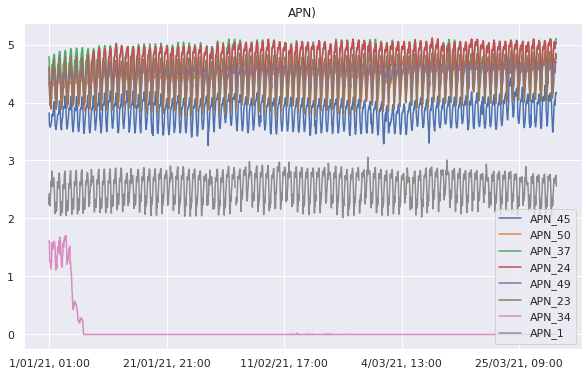

In [ ]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    page_labels = sample['Unnamed: 0'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('APN)')
    plt.legend(page_labels)
    
plot_random_series(df, 6)

In [ ]:
df = df.set_index('Unnamed: 0')

In [ ]:
from datetime import timedelta

pred_steps = 1
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1) 

In [ ]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

In [ ]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2021-01-01 01:00:00 - 2021-03-29 23:00:00
Train prediction: 2021-03-30 23:00:00 - 2021-03-30 23:00:00 

Val encoding: 2021-01-02 01:00:00 - 2021-03-30 23:00:00
Val prediction: 2021-03-31 23:00:00 - 2021-03-31 23:00:00

Encoding interval: 88
Prediction interval: 1


In [ ]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values
# # Scaling
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(series_array)
# series_array = scaler.transform(series_array)

print(series_array.shape)

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

(50, 2159)


In [ ]:
date_to_index[:5]

2021-01-01 01:00:00    0
2021-01-01 02:00:00    1
2021-01-01 03:00:00    2
2021-01-01 04:00:00    3
2021-01-01 05:00:00    4
dtype: int64

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from tensorflow.keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1, activation='linear')(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':1})(x)

model = Model(history_seq, pred_seq_train)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          96        
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          2080  

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
first_n_samples = 40000
batch_size = 2**11
epochs = 50

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Epoch 1/50
1/1 [==============================] - 10s 10s/step - loss: 0.2721 - val_loss: 0.2509
Epoch 2/50
1/1 [==============================] - 0s 87ms/step - loss: 0.2229 - val_loss: 0.2267
Epoch 3/50
1/1 [==============================] - 0s 85ms/step - loss: 0.1968 - val_loss: 0.1952
Epoch 4/50
1/1 [==============================] - 0s 91ms/step - loss: 0.1544 - val_loss: 0.1515
Epoch 5/50
1/1 [==============================] - 0s 83ms/step - loss: 0.0977 - val_loss: 0.0931
Epoch 6/50
1/1 [==============================] - 0s 85ms/step - loss: 0.0473 - val_loss: 0.0665
Epoch 7/50
1/1 [==============================] - 0s 83ms/step - loss: 0.0731 - val_loss: 0.0681
Epoch 8/50
1/1 [==============================] - 0s 93ms/step - loss: 0.0820 - val_loss: 0.0646
Epoch 9/50
1/1 [==============================] - 0s 87ms/step - loss: 0.0729 - val_loss: 0.0825
Epoch 10/50
1/1 [==============================] - 0s 84ms/step - loss: 0.0417 - val_loss: 0.1073
Epoch 11/50
1/1 [============

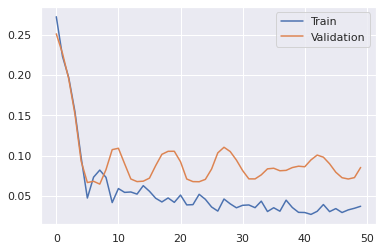

In [ ]:
# plot history
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [ ]:
# VAlidation
# sample of series from train_enc_start to train_enc_end  
val_input_data = get_time_block_series(series_array, date_to_index, 
                                           val_enc_start, val_enc_end)[:first_n_samples]
val_input_data, val_encode_series_mean = transform_series_encode(val_input_data)

# sample of series from train_pred_start to train_pred_end 
val_target_data = get_time_block_series(series_array, date_to_index, 
                                            val_pred_start, val_pred_end)[:first_n_samples]
val_target_data = transform_series_decode(val_target_data, val_encode_series_mean)


In [ ]:
model.predict(val_input_data).reshape(1, 50)

array([[ 0.03359708,  0.0974535 ,  0.3363374 ,  0.32627624,  0.32027748,
         0.2767909 ,  0.28431967,  0.27971795,  0.29399154,  0.26803967,
         0.28650793,  0.27418408,  0.27829266,  0.28295243,  0.2697481 ,
         0.3018798 ,  0.33157656,  0.32184243,  0.314831  ,  0.3446658 ,
         0.3382326 ,  0.30836418,  0.3237428 ,  0.296748  , -0.00085187,
        -0.01789434, -0.01790293, -0.01791144, -0.01789434, -0.01789434,
        -0.02018674, -0.01789434, -0.01796302, -0.01803148, -0.01792009,
        -0.01798866,  0.318775  ,  0.27766865,  0.32894644,  0.21221375,
         0.244554  ,  0.23505417,  0.14124192,  0.20104639,  0.24906717,
         0.12917678,  0.18890229,  0.15242153,  0.17711821,  0.27143925]],
      dtype=float32)

In [ ]:
val_target_data.reshape(1, 50)

array([[-9.31086361e-04,  4.95204099e-02,  3.44671105e-01,
         3.38522361e-01,  3.44097081e-01,  2.06677510e-01,
         3.02180480e-01,  2.66660784e-01,  3.11892941e-01,
         2.85655416e-01,  2.91397475e-01,  2.90068078e-01,
         2.78939746e-01,  2.74241927e-01,  2.54491684e-01,
         2.13093390e-01,  2.64051683e-01,  2.61612035e-01,
         2.48281159e-01,  2.93166058e-01,  2.83484558e-01,
         2.05162623e-01,  2.94840797e-01,  2.49766044e-01,
         2.72882083e-02,  0.00000000e+00, -7.15336510e-06,
        -1.42362525e-05,  0.00000000e+00,  0.00000000e+00,
        -1.90145604e-03,  0.00000000e+00, -5.72269208e-05,
        -1.14312886e-04, -2.14600953e-05, -7.86165384e-05,
         3.47848729e-01,  2.95637685e-01,  2.98931636e-01,
         2.07578985e-01,  3.48254536e-01,  3.13255178e-01,
         3.31846959e-01,  3.19856683e-01,  3.07543679e-01,
         1.42067729e-01,  2.36668654e-01,  2.27765870e-01,
         2.09635355e-01,  3.75722125e-01]])

In [ ]:
predicted = model.predict(val_input_data).reshape(50, 1)

In [ ]:
#predicted.reshape(1, 1)

In [ ]:
ytrue = val_target_data.reshape(50, 1)

In [ ]:
# Performance metrics
mae_metr = mean_absolute_error(ytrue, predicted)
mape_metr = mean_absolute_percentage_error(ytrue, predicted)
mse_metr = mean_squared_error(ytrue, predicted)
rmse_metr = np.sqrt(mse_metr)
mase_metr = mean_absolute_scaled_error(ytrue, predicted, decoder_target_data.reshape(50, 1))
    
print("MAE  : ", mae_metr)
print("MAPE : ", mape_metr)
print("MSE  : ", mse_metr)
print("RMSE : ", rmse_metr)
print("MASE : ", mase_metr)
print("==============")

MAE  :  0.04013872607121453
MAPE :  6447116352332.184
MSE  :  0.0029590521814954487
RMSE :  0.05439717071222959
MASE :  0.5644417708001821


In [ ]:
ytrue.shape, predicted.shape, decoder_target_data.shape

((50, 1), (50, 1), (50, 1, 1))

In [ ]:
# Feature metrics
for i in range(len(ytrue)):
    mae_metr = mean_absolute_error(ytrue[i], predicted[i])
    mape_metr = mean_absolute_percentage_error(ytrue[i], predicted[i])
    mse_metr = mean_squared_error(ytrue[i], predicted[i])
    rmse_metr = np.sqrt(mse_metr)
    #mase_metr = mean_absolute_scaled_error(ytrue, predicted, decoder_target_data.reshape(50, 1))
    print(apn.columns[i])
    print("MAE  : ", mae_metr)
    print("MAPE : ", mape_metr)
    print("MSE  : ", mse_metr)
    print("RMSE : ", rmse_metr)
    #print("MASE : ", mase_metr)
    print("==============")

APN_1
MAE  :  0.03452816826075544
MAPE :  37.08374400361727
MSE  :  0.0011921944034430395
RMSE :  0.03452816826075544
APN_2
MAE  :  0.04793309489627573
MAPE :  0.9679462465818535
MSE  :  0.0022975815863353743
RMSE :  0.04793309489627573
APN_3
MAE  :  0.008333716962111382
MAPE :  0.024178751432101207
MSE  :  6.945083840458295e-05
RMSE :  0.008333716962111382
APN_4
MAE  :  0.01224611806024889
MAPE :  0.036175211680412725
MSE  :  0.00014996740754555404
RMSE :  0.01224611806024889
APN_5
MAE  :  0.023819599029369698
MAPE :  0.06922348466118955
MSE  :  0.0005673732979199498
RMSE :  0.023819599029369698
APN_6
MAE  :  0.07011337687462849
MAPE :  0.3392404756196035
MSE  :  0.004915885616763689
RMSE :  0.07011337687462849
APN_7
MAE  :  0.01786081109120552
MAPE :  0.05910643561532089
MSE  :  0.0003190085728357301
RMSE :  0.01786081109120552
APN_8
MAE  :  0.013057168057606816
MAPE :  0.048965460402269866
MSE  :  0.00017048963768458777
RMSE :  0.013057168057606816
APN_9
MAE  :  0.017901405210237975

In [ ]:
len(ytrue.reshape(1, 50))

1

In [ ]:
encoder_input_data.shape

(50, 2111, 1)

In [ ]:
def forecast(model, series, period):
    predictions = []
    last_tmstep = None
    for p in range(0, period):
        if p == 0:
            last_tmstep = series[-50:]
            
        temp = last_tmstep
        future_pred = model.predict(last_tmstep)#.reshape(1, 50)
        predictions.append(scaler.inverse_transform(future_pred.reshape(temp.shape[2], temp.shape[0])))
        init_last_tmstep = last_tmstep.reshape(temp.shape[0], temp.shape[1])
        rest_vals = init_last_tmstep
        last_tmstep = np.append(rest_vals, future_pred.reshape(temp.shape[0], temp.shape[2]), axis=1)
        last_tmstep = last_tmstep.reshape(last_tmstep.shape[1], temp.shape[0])[1:]
        last_tmstep = last_tmstep.reshape(temp.shape[0], temp.shape[1] )
        last_tmstep = last_tmstep.reshape(temp.shape[0], temp.shape[1], temp.shape[2])
    return predictions

In [ ]:
def plot_forecasts(df):
    fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=False)
    axx = axs.ravel()
    for i in range(0, 10):
        df[df.columns[i]].loc[str(df.iloc[[0]].index[0]).split(' ')[0] : str(df.iloc[[len(df)-1]].index[0]).split(' ')[0]].plot(ax=axx[i])
        axx[i].set_xlabel("date")
        axx[i].set_ylabel(df.columns[i])  

## 7 Days Forecast

In [ ]:
f7d = np.array(forecast(model, encoder_input_data, 168)).reshape(168, 50)

In [ ]:
cols = apn.columns

In [ ]:
f7day = pd.DataFrame(f7d,columns=cols)

In [ ]:
f7day["Date"] = pd.date_range(start= '2021-04-01', periods=168, freq='1H')
f7day = f7day.set_index("Date")

In [ ]:
f7day.head()

,APN_1,APN_2,APN_3,APN_4,APN_5,APN_6,APN_7,APN_8,APN_9,APN_10,APN_11,APN_12,APN_13,APN_14,APN_15,APN_16,APN_17,APN_18,APN_19,APN_20,APN_21,APN_22,APN_23,APN_24,APN_25,APN_26,APN_27,APN_28,APN_29,APN_30,APN_31,APN_32,APN_33,APN_34,APN_35,APN_36,APN_37,APN_38,APN_39,APN_40,APN_41,APN_42,APN_43,APN_44,APN_45,APN_46,APN_47,APN_48,APN_49,APN_50
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-01 00:00:00,12.273835,5.332158,65.220253,73.981804,131.732941,114.467987,103.987404,82.892921,86.132599,83.152840,64.019707,150.082581,68.307060,84.465477,186.353271,61.556526,60.576553,68.536507,74.621651,64.537270,64.619614,65.352829,94.876228,125.784790,0.039117,0.099936,0.023207,0.048693,0.081045,0.098334,0.100262,0.096384,0.092942,0.103236,0.004418,0.089909,125.798447,108.169823,71.702423,51.324894,38.543213,50.555325,60.645828,55.283127,49.213661,53.356560,71.672211,87.788673,89.727646,86.905403
2021-04-01 01:00:00,12.253873,5.229853,64.329529,72.756996,129.328094,110.129402,99.099960,78.278908,81.086067,78.131569,59.948982,140.593719,63.257866,78.110970,171.589340,54.664249,53.662727,60.778381,66.090378,57.575329,58.092182,59.480442,87.125114,120.913277,0.041122,0.190000,0.062365,0.101291,0.146997,0.153781,0.150514,0.141125,0.139274,0.107665,0.006102,0.096308,115.765411,101.026459,65.349342,48.775070,36.674969,48.127712,57.140804,52.664780,46.918098,50.356899,69.428604,86.672852,89.289070,86.760536
2021-04-01 02:00:00,12.065953,5.083126,64.396408,71.341034,124.108505,106.649689,96.466187,76.430756,78.470520,76.549194,58.822678,139.807709,64.163521,81.215065,183.929001,59.454456,57.206097,63.657669,68.389877,58.479752,58.145470,58.353268,84.154289,115.627342,0.043128,0.188700,0.103897,0.153109,0.203283,0.236162,0.226910,0.214764,0.208934,0.121927,0.008338,0.071659,116.825752,106.629448,71.324387,50.972317,37.864449,49.174973,57.706131,52.766685,46.586056,49.887543,68.068405,84.823784,88.117706,86.261665
2021-04-01 03:00:00,11.925757,4.993616,64.171394,68.546341,118.898956,104.563026,94.276993,75.055687,77.977905,78.966125,62.456909,143.077988,63.480827,77.599274,171.696518,54.027252,53.361084,62.109489,72.556526,60.873009,59.523201,59.365242,84.854637,114.945312,0.046776,0.241835,0.125049,0.180145,0.235962,0.269113,0.231664,0.246987,0.241540,0.121610,0.008579,0.093976,117.493210,101.025085,64.932129,48.697392,36.874332,50.182758,58.837769,54.882843,47.491329,51.506439,68.377876,84.081169,87.092728,85.223587
2021-04-01 04:00:00,11.955945,5.124832,64.414902,67.308685,117.663086,103.114868,95.040939,77.265892,82.488640,77.544182,58.428734,137.461578,62.454407,77.858826,184.244476,55.748985,53.500431,59.669922,65.011185,58.200603,62.288273,61.429714,84.819885,115.141876,0.049253,0.229907,0.172051,0.230596,0.437206,0.484486,0.375840,0.306054,0.306821,0.125691,0.009421,0.065465,112.508263,102.673347,70.802116,50.175438,36.819618,48.388130,56.379940,53.649494,48.954964,52.130577,68.997643,84.343262,86.554428,84.343201


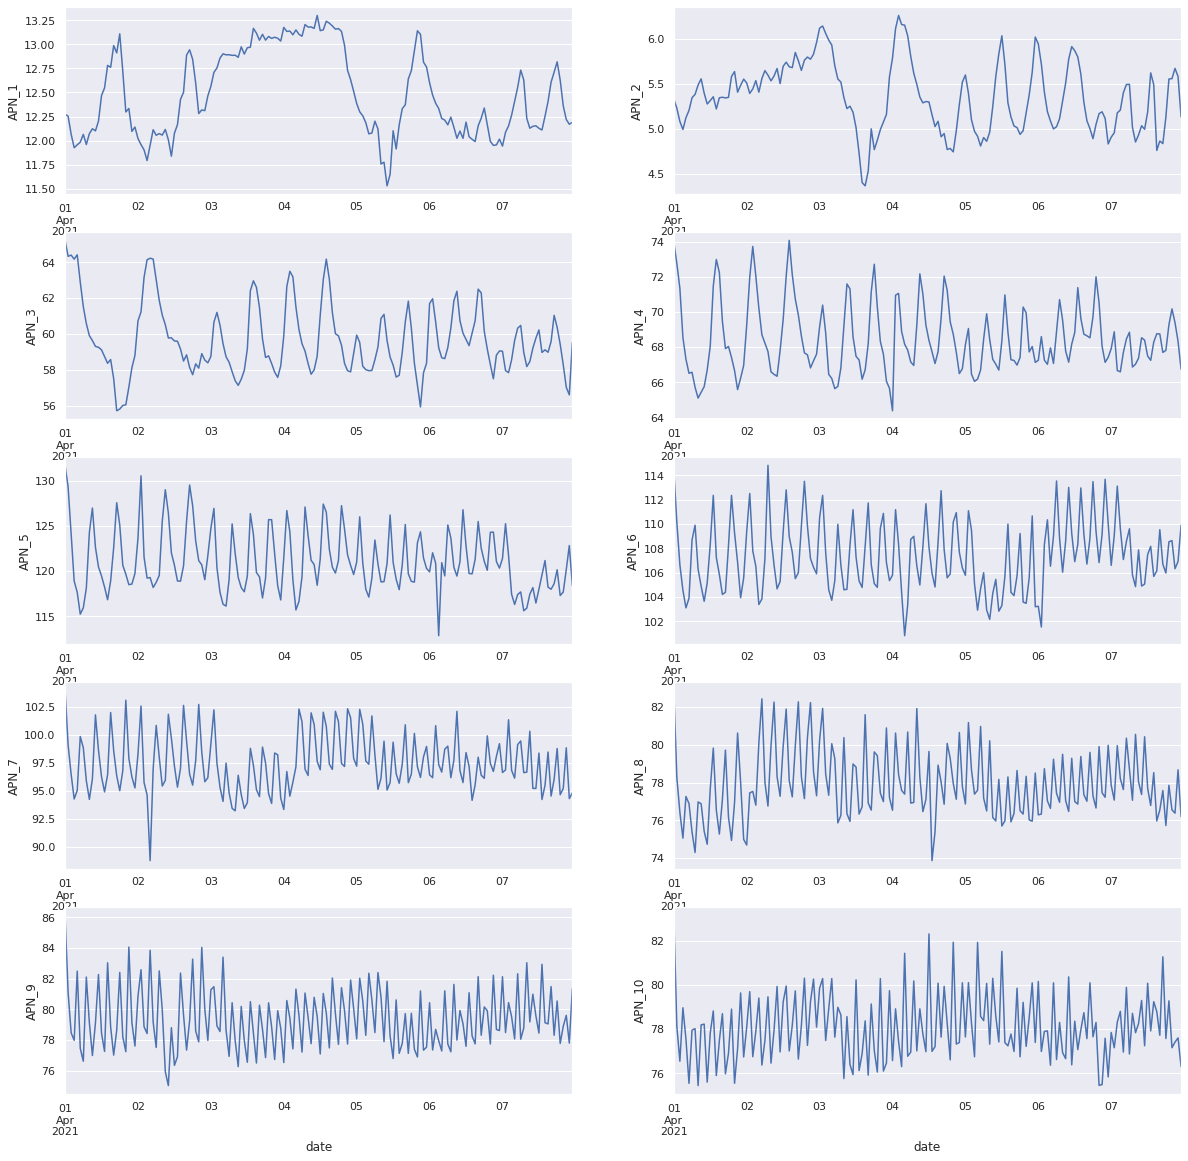

In [ ]:
plot_forecasts(f7day)

## 15 Days Forecast

In [ ]:
f15 = np.array(forecast(model, encoder_input_data, 360)).reshape(360, 50)

In [ ]:
cols = apn.columns

In [ ]:
f15d = pd.DataFrame(f15,columns=cols)

In [ ]:
f15d["Date"] = pd.date_range(start= '2021-04-01', periods=360, freq='1H')
f15d = f15d.set_index("Date")

In [ ]:
f15d.head()

,APN_1,APN_2,APN_3,APN_4,APN_5,APN_6,APN_7,APN_8,APN_9,APN_10,APN_11,APN_12,APN_13,APN_14,APN_15,APN_16,APN_17,APN_18,APN_19,APN_20,APN_21,APN_22,APN_23,APN_24,APN_25,APN_26,APN_27,APN_28,APN_29,APN_30,APN_31,APN_32,APN_33,APN_34,APN_35,APN_36,APN_37,APN_38,APN_39,APN_40,APN_41,APN_42,APN_43,APN_44,APN_45,APN_46,APN_47,APN_48,APN_49,APN_50
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-01 00:00:00,12.273835,5.332158,65.220253,73.981804,131.732941,114.467987,103.987404,82.892921,86.132599,83.152840,64.019707,150.082581,68.307060,84.465477,186.353271,61.556526,60.576553,68.536507,74.621651,64.537270,64.619614,65.352829,94.876228,125.784790,0.039117,0.099936,0.023207,0.048693,0.081045,0.098334,0.100262,0.096384,0.092942,0.103236,0.004418,0.089909,125.798447,108.169823,71.702423,51.324894,38.543213,50.555325,60.645828,55.283127,49.213661,53.356560,71.672211,87.788673,89.727646,86.905403
2021-04-01 01:00:00,12.253873,5.229853,64.329529,72.756996,129.328094,110.129402,99.099960,78.278908,81.086067,78.131569,59.948982,140.593719,63.257866,78.110970,171.589340,54.664249,53.662727,60.778381,66.090378,57.575329,58.092182,59.480442,87.125114,120.913277,0.041122,0.190000,0.062365,0.101291,0.146997,0.153781,0.150514,0.141125,0.139274,0.107665,0.006102,0.096308,115.765411,101.026459,65.349342,48.775070,36.674969,48.127712,57.140804,52.664780,46.918098,50.356899,69.428604,86.672852,89.289070,86.760536
2021-04-01 02:00:00,12.065953,5.083126,64.396408,71.341034,124.108505,106.649689,96.466187,76.430756,78.470520,76.549194,58.822678,139.807709,64.163521,81.215065,183.929001,59.454456,57.206097,63.657669,68.389877,58.479752,58.145470,58.353268,84.154289,115.627342,0.043128,0.188700,0.103897,0.153109,0.203283,0.236162,0.226910,0.214764,0.208934,0.121927,0.008338,0.071659,116.825752,106.629448,71.324387,50.972317,37.864449,49.174973,57.706131,52.766685,46.586056,49.887543,68.068405,84.823784,88.117706,86.261665
2021-04-01 03:00:00,11.925757,4.993616,64.171394,68.546341,118.898956,104.563026,94.276993,75.055687,77.977905,78.966125,62.456909,143.077988,63.480827,77.599274,171.696518,54.027252,53.361084,62.109489,72.556526,60.873009,59.523201,59.365242,84.854637,114.945312,0.046776,0.241835,0.125049,0.180145,0.235962,0.269113,0.231664,0.246987,0.241540,0.121610,0.008579,0.093976,117.493210,101.025085,64.932129,48.697392,36.874332,50.182758,58.837769,54.882843,47.491329,51.506439,68.377876,84.081169,87.092728,85.223587
2021-04-01 04:00:00,11.955945,5.124832,64.414902,67.308685,117.663086,103.114868,95.040939,77.265892,82.488640,77.544182,58.428734,137.461578,62.454407,77.858826,184.244476,55.748985,53.500431,59.669922,65.011185,58.200603,62.288273,61.429714,84.819885,115.141876,0.049253,0.229907,0.172051,0.230596,0.437206,0.484486,0.375840,0.306054,0.306821,0.125691,0.009421,0.065465,112.508263,102.673347,70.802116,50.175438,36.819618,48.388130,56.379940,53.649494,48.954964,52.130577,68.997643,84.343262,86.554428,84.343201


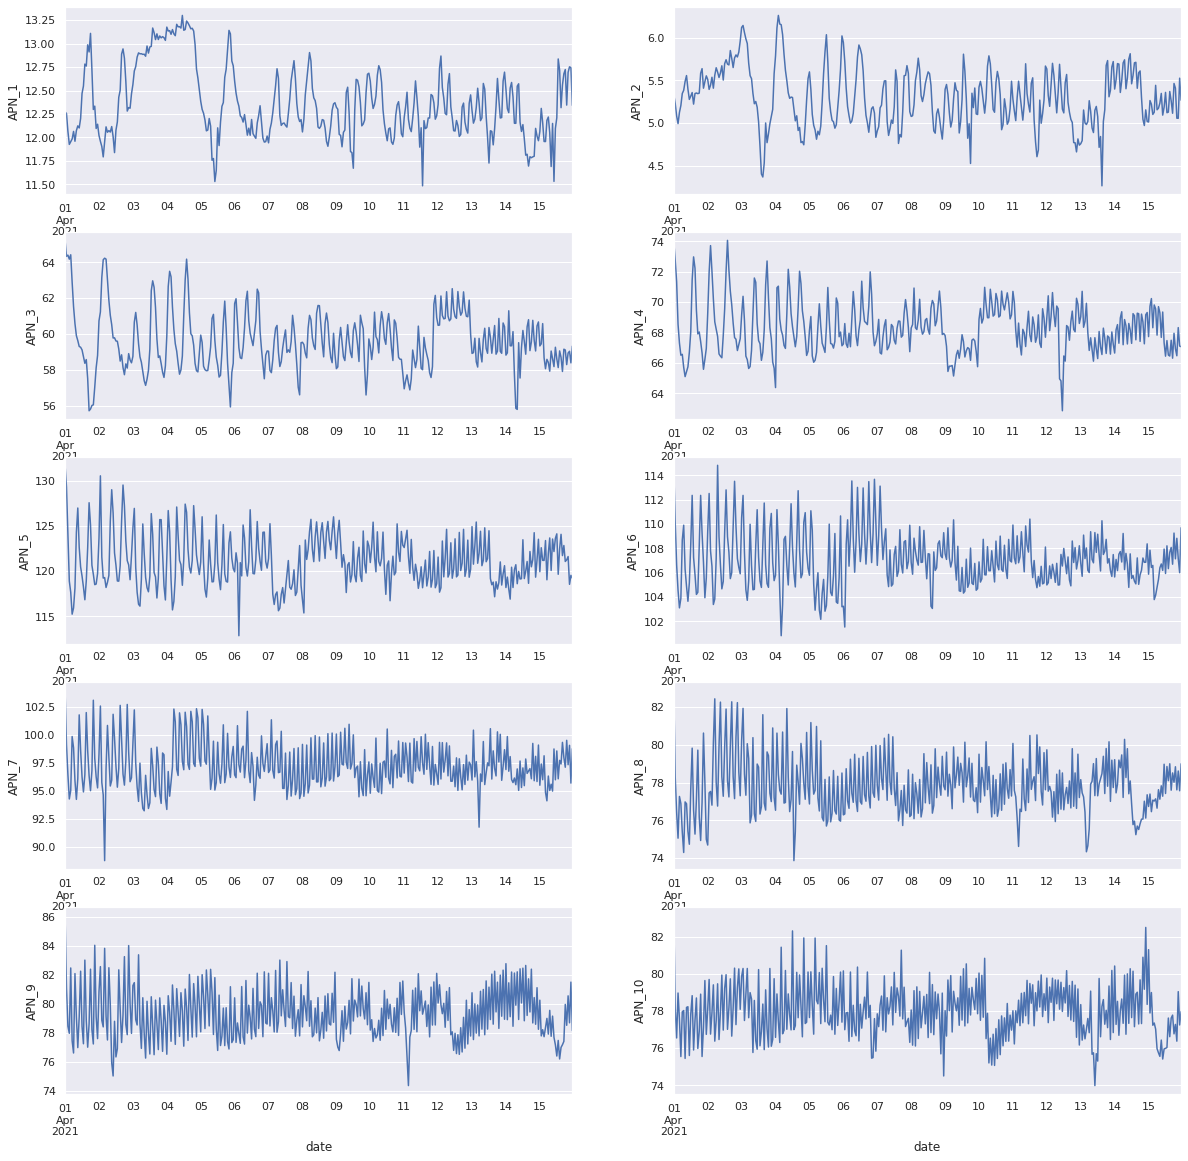

In [ ]:
plot_forecasts(f15d)

## One Month Forecast

In [ ]:
f1 = np.array(forecast(model, encoder_input_data, 720)).reshape(720, 50)

In [ ]:
cols = apn.columns

In [ ]:
f1m = pd.DataFrame(f1,columns=cols)

In [ ]:
f1m["Date"] = pd.date_range(start= '2021-04-07', periods=720, freq='1H')
f1m = f1m.set_index("Date")

In [ ]:
f1m.head()

,APN_1,APN_2,APN_3,APN_4,APN_5,APN_6,APN_7,APN_8,APN_9,APN_10,APN_11,APN_12,APN_13,APN_14,APN_15,APN_16,APN_17,APN_18,APN_19,APN_20,APN_21,APN_22,APN_23,APN_24,APN_25,APN_26,APN_27,APN_28,APN_29,APN_30,APN_31,APN_32,APN_33,APN_34,APN_35,APN_36,APN_37,APN_38,APN_39,APN_40,APN_41,APN_42,APN_43,APN_44,APN_45,APN_46,APN_47,APN_48,APN_49,APN_50
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-07 00:00:00,12.273835,5.332158,65.220253,73.981804,131.732941,114.467987,103.987404,82.892921,86.132599,83.152840,64.019707,150.082581,68.307060,84.465477,186.353271,61.556526,60.576553,68.536507,74.621651,64.537270,64.619614,65.352829,94.876228,125.784790,0.039117,0.099936,0.023207,0.048693,0.081045,0.098334,0.100262,0.096384,0.092942,0.103236,0.004418,0.089909,125.798447,108.169823,71.702423,51.324894,38.543213,50.555325,60.645828,55.283127,49.213661,53.356560,71.672211,87.788673,89.727646,86.905403
2021-04-07 01:00:00,12.253873,5.229853,64.329529,72.756996,129.328094,110.129402,99.099960,78.278908,81.086067,78.131569,59.948982,140.593719,63.257866,78.110970,171.589340,54.664249,53.662727,60.778381,66.090378,57.575329,58.092182,59.480442,87.125114,120.913277,0.041122,0.190000,0.062365,0.101291,0.146997,0.153781,0.150514,0.141125,0.139274,0.107665,0.006102,0.096308,115.765411,101.026459,65.349342,48.775070,36.674969,48.127712,57.140804,52.664780,46.918098,50.356899,69.428604,86.672852,89.289070,86.760536
2021-04-07 02:00:00,12.065953,5.083126,64.396408,71.341034,124.108505,106.649689,96.466187,76.430756,78.470520,76.549194,58.822678,139.807709,64.163521,81.215065,183.929001,59.454456,57.206097,63.657669,68.389877,58.479752,58.145470,58.353268,84.154289,115.627342,0.043128,0.188700,0.103897,0.153109,0.203283,0.236162,0.226910,0.214764,0.208934,0.121927,0.008338,0.071659,116.825752,106.629448,71.324387,50.972317,37.864449,49.174973,57.706131,52.766685,46.586056,49.887543,68.068405,84.823784,88.117706,86.261665
2021-04-07 03:00:00,11.925757,4.993616,64.171394,68.546341,118.898956,104.563026,94.276993,75.055687,77.977905,78.966125,62.456909,143.077988,63.480827,77.599274,171.696518,54.027252,53.361084,62.109489,72.556526,60.873009,59.523201,59.365242,84.854637,114.945312,0.046776,0.241835,0.125049,0.180145,0.235962,0.269113,0.231664,0.246987,0.241540,0.121610,0.008579,0.093976,117.493210,101.025085,64.932129,48.697392,36.874332,50.182758,58.837769,54.882843,47.491329,51.506439,68.377876,84.081169,87.092728,85.223587
2021-04-07 04:00:00,11.955945,5.124832,64.414902,67.308685,117.663086,103.114868,95.040939,77.265892,82.488640,77.544182,58.428734,137.461578,62.454407,77.858826,184.244476,55.748985,53.500431,59.669922,65.011185,58.200603,62.288273,61.429714,84.819885,115.141876,0.049253,0.229907,0.172051,0.230596,0.437206,0.484486,0.375840,0.306054,0.306821,0.125691,0.009421,0.065465,112.508263,102.673347,70.802116,50.175438,36.819618,48.388130,56.379940,53.649494,48.954964,52.130577,68.997643,84.343262,86.554428,84.343201


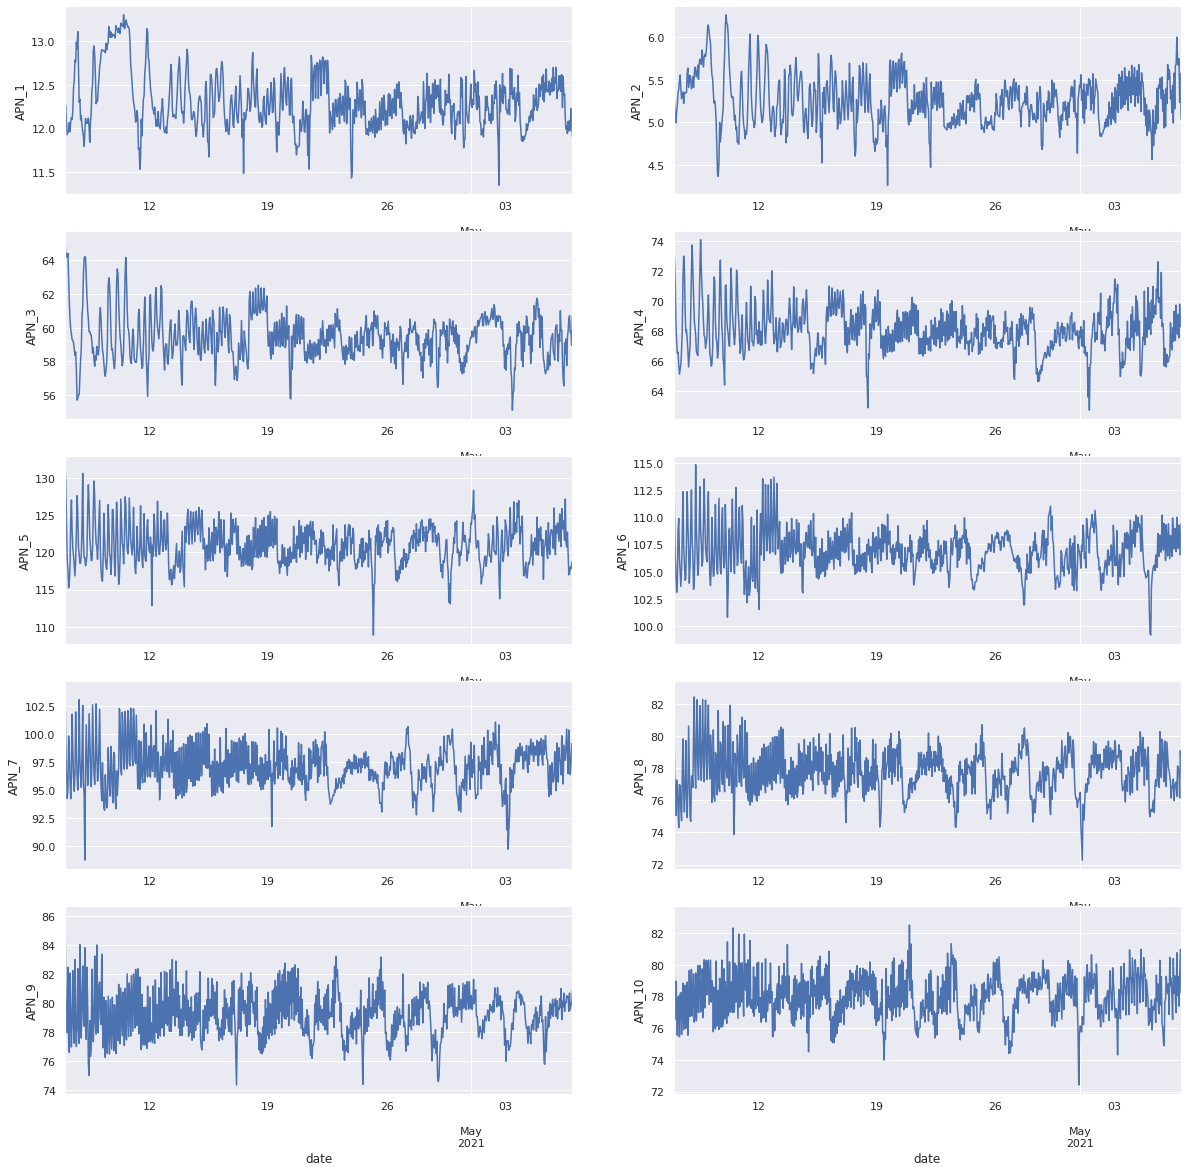

In [ ]:
plot_forecasts(f1m)